In [1]:
# Jupyter notebook for runZero's KEVology and KEV Collider
# Copyright (c) 2026 runZero, Inc.
#
# Paper:  https://www.runzero.com/kevology
# App:    https://runzero.com/kev-collider
# GitHub: https://github.com/runZeroInc/kev-collider-data

# Each cell should be run in order, since later cells tend to depend on earlier ones for requires, populated dataframes, shared variables, etc

# Yes, this is written in Ruby. You're welcome, haters.

require 'json'
require 'csv'
require 'date'
require 'iruby'
require 'base64'
require 'daru'
require 'gruff'

COLLIDER_JSON_DIR = './json/*.json'
json_files = Dir.glob(COLLIDER_JSON_DIR)

title = "<h1>Setup: All the things we care about</h1>"
IRuby.display IRuby.html(title)

records = json_files.map do |file|
  data = JSON.parse(File.read(file)) rescue next
  kev = data['kev'] || {}
  cve = data['cve'] || {}
  cve_metadata = cve['metadata'] || {}
  assertions = cve.dig('assertions') || {}
  cvss = assertions['cvss'] || {}
  ssvc = assertions.dig('ssvc','options') || {}
  epss = data['epss'] || {}
  metasploit = data.dig('metasploit','modules') || []
  nuclei = data.dig('nuclei','templates') || []
  attck_enterprise = data.dig('attck','enterprise') || []
  attck_mobile = data.dig('attck','mobile') || []

  date_generated = begin
    DateTime.parse(data['dateGenerated']) if data['dateGenerated']
  rescue
    nil
  end

  kev_date_added = begin
    Date.parse(kev['dateAdded']) if kev['dateAdded']
  rescue
    nil
  end

  kev_date_due = begin
    Date.parse(kev['dateDue']) if kev['dateDue']
  rescue
    nil
  end

    # CVE data    
    cve_date_added =
    if !data['cveDataPresent'] || cve_metadata['datePublished'].nil?
      nil
    else
      DateTime.parse(cve_metadata['datePublished']) rescue nil
    end

  metasploit_first_commit =
    metasploit
      .map { |m| m['firstCommitDate'] }
      .compact
      .map { |d| DateTime.parse(d) rescue nil }
      .compact
      .min

      nuclei_first_commit =
    nuclei
      .map { |m| m['firstCommitDate'] }
      .compact
      .map { |d| DateTime.parse(d) rescue nil }
      .compact
      .min

    first_commodity_commit = [metasploit_first_commit, nuclei_first_commit].compact.min


  {
    # Top-level metadata
    cve_id: data['cveID'],
    schema_version: data['schemaVersion'],
    date_generated: date_generated,
    cve_data_present: data['cveDataPresent'],

    # KEV fields
    kev_vulnerability_name: kev['vulnerabilityName'],
    kev_vendor_project: kev['vendorProject'],
    kev_date_added: kev_date_added,
    kev_day_added: kev['dayAdded'],
    kev_date_due: kev_date_due,
    kev_days_allotted: kev['daysAllotted'],
    kev_short_deadline: kev['daysAllotted'] && kev['daysAllotted'] < 21,
    kev_ransomware: kev['ransomware'],
    kev_holiday: kev['holidayAdded'],

    # CVE data
    cve_date_added: cve_date_added,
    
    # CVSS fields
    cvss_version: cvss['version'],
    cvss_attack_vector: cvss['attackVector'],
    cvss_attack_complexity: cvss['attackComplexity'],
    cvss_privileges_required: cvss['privilegesRequired'],
    cvss_scope: cvss['scope'],
    cvss_user_interaction: cvss['userInteraction'],
    cvss_confidentiality_impact: cvss['confidentialityImpact'],
    cvss_integrity_impact: cvss['integrityImpact'],
    cvss_availability_impact: cvss['availabilityImpact'],
    cvss_vector_string: cvss['vectorString'],
    cvss_base_score: cvss['baseScore'],
    cvss_base_severity: cvss['baseSeverity'],

    # CWE fields
    kev_cwes: (kev['cwes'] || []).join('|'),
    cve_cwes: (cve['cwes'] || []).join('|'),

    # SSVC fields
    ssvc_exploitation: ssvc['exploitation'],
    ssvc_automatable: ssvc['automatable'],
    ssvc_technical_impact: ssvc['technicalImpact'],
      
    # Metasploit
    has_metasploit: !metasploit.empty?,
    metasploit_modules: metasploit,
    metasploit_module_count: metasploit.size,
    metasploit_first_commit: metasploit_first_commit,
    min_metasploit_delta: metasploit.map { |m| m['deltaFromKev'] }.compact.min,
    
    # Nuclei
    has_nuclei: !nuclei.empty?,
    nuclei_template_count: nuclei.size,
    nuclei_first_commit: nuclei_first_commit,
    min_nuclei_delta: nuclei.map { |t| t['deltaFromKev'] }.compact.min,
    
    # Commodity exploits
    has_commodity_exploit: (!nuclei.empty? || !metasploit.empty?),
    commodity_exploit_first_commit: first_commodity_commit,
      
    # EPSS fields
    epss_today: epss['todayScore'],
    epss_percentile: epss['todayPercentile'],
    epss_delta: epss['deltaScore'],

    # ATT&CK
    attck_enterprise: attck_enterprise,
    has_attck_enterprise: !attck_enterprise.empty?,
    attck_enterprise_technique_count: attck_enterprise.size,
    attck_enterprise_capability_groups: attck_enterprise.map { |t| t['capabilityGroup'] }.uniq.join('|'),
    attck_mobile: attck_mobile,
    has_attck_mobile: !attck_mobile.empty?,
    has_attck: (!attck_enterprise.empty? || !attck_mobile.empty?),
    attck_mobile_technique_count: attck_mobile.size,
    attck_mobile_capability_groups: attck_mobile.map { |t| t['capabilityGroup'] }.uniq.join('|')
  }
end.compact

df = Daru::DataFrame.new(records)

vectors = df.vectors.to_a
puts vectors.inspect
df.where(df[:cve_id].eq('CVE-2021-44228'))


"<h1>Setup: All the things we care about</h1>"

[:cve_id, :schema_version, :date_generated, :cve_data_present, :kev_vulnerability_name, :kev_vendor_project, :kev_date_added, :kev_day_added, :kev_date_due, :kev_days_allotted, :kev_short_deadline, :kev_ransomware, :kev_holiday, :cve_date_added, :cvss_version, :cvss_attack_vector, :cvss_attack_complexity, :cvss_privileges_required, :cvss_scope, :cvss_user_interaction, :cvss_confidentiality_impact, :cvss_integrity_impact, :cvss_availability_impact, :cvss_vector_string, :cvss_base_score, :cvss_base_severity, :kev_cwes, :cve_cwes, :ssvc_exploitation, :ssvc_automatable, :ssvc_technical_impact, :has_metasploit, :metasploit_modules, :metasploit_module_count, :metasploit_first_commit, :min_metasploit_delta, :has_nuclei, :nuclei_template_count, :nuclei_first_commit, :min_nuclei_delta, :has_commodity_exploit, :commodity_exploit_first_commit, :epss_today, :epss_percentile, :epss_delta, :attck_enterprise, :has_attck_enterprise, :attck_enterprise_technique_count, :attck_enterprise_capability_group

,cve_id,schema_version,date_generated,cve_data_present,kev_vulnerability_name,kev_vendor_project,kev_date_added,kev_day_added,kev_date_due,kev_days_allotted,kev_short_deadline,kev_ransomware,kev_holiday,cve_date_added,cvss_version,cvss_attack_vector,cvss_attack_complexity,cvss_privileges_required,cvss_scope,cvss_user_interaction,cvss_confidentiality_impact,cvss_integrity_impact,cvss_availability_impact,cvss_vector_string,cvss_base_score,cvss_base_severity,kev_cwes,cve_cwes,ssvc_exploitation,ssvc_automatable,ssvc_technical_impact,has_metasploit,metasploit_modules,metasploit_module_count,metasploit_first_commit,min_metasploit_delta,has_nuclei,nuclei_template_count,nuclei_first_commit,min_nuclei_delta,has_commodity_exploit,commodity_exploit_first_commit,epss_today,epss_percentile,epss_delta,attck_enterprise,has_attck_enterprise,attck_enterprise_technique_count,attck_enterprise_capability_groups,attck_mobile,has_attck_mobile,has_attck,attck_mobile_technique_count,attck_mobile_capability_groups
889,CVE-2021-44228,1.0.0-dev,2026-01-28T16:28:41+00:00,true,Apache Log4j2 Remote Code Execution,Apache,2021-12-10,Friday,2021-12-24,14,true,true,,2021-12-10T00:00:00+00:00,3.1,NETWORK,LOW,NONE,CHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H,10.0,CRITICAL,CWE-20|CWE-400|CWE-502,,active,yes,total,true,"[{""module""=>""auxiliary/scanner/http/log4shell_scanner.rb"", ""firstCommitDate""=>""2021-12-13T17:36:45.000Z"", ""deltaFromCve""=>3, ""deltaFromKev""=>3}, {""module""=>""exploits/multi/http/log4shell_header_injection.rb"", ""firstCommitDate""=>""2021-12-16T16:27:46.000Z"", ""deltaFromCve""=>6, ""deltaFromKev""=>6}, {""module""=>""exploits/multi/http/vmware_vcenter_log4shell.rb"", ""firstCommitDate""=>""2022-01-12T20:34:45.000Z"", ""deltaFromCve""=>33, ""deltaFromKev""=>33}, {""module""=>""exploits/multi/http/ubiquiti_unifi_log4shell.rb"", ""firstCommitDate""=>""2022-01-14T15:12:02.000Z"", ""deltaFromCve""=>35, ""deltaFromKev""=>35}, {""module""=>""exploits/linux/http/mobileiron_core_log4shell.rb"", ""firstCommitDate""=>""2022-07-29T17:31:15.000Z"", ""deltaFromCve""=>231, ""deltaFromKev""=>231}]",5,2021-12-13T17:36:45+00:00,3,true,44,2021-12-11T19:26:50+00:00,1,true,2021-12-11T19:26:50+00:00,0.94358,0.99959,0.0,"[{""mappingType""=>""exploitation_technique"", ""id""=>""T1190"", ""name""=>""Exploit Public-Facing Application"", ""capabilityGroup""=>""code_execution"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""secondary_impact"", ""id""=>""T1496"", ""name""=>""Resource Hijacking"", ""capabilityGroup""=>""code_execution"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""secondary_impact"", ""id""=>""T1486"", ""name""=>""Data Encrypted for Impact"", ""capabilityGroup""=>""code_execution"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""secondary_impact"", ""id""=>""T1608.001"", ""name""=>""Upload Malware"", ""capabilityGroup""=>""code_execution"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""secondary_impact"", ""id""=>""T1505.003"", ""name""=>""Web Shell"", ""capabilityGroup""=>""code_execution"", ""source""=>""CTID-7/28/2025""}]",true,5,code_execution,[],false,true,0,


In [2]:
recent_cves = %w[
CVE-2025-14847
CVE-2023-52163
CVE-2025-14733
CVE-2025-20393
CVE-2025-40602
CVE-2025-59374
CVE-2025-59718
CVE-2025-14611
CVE-2025-43529
CVE-2018-4063
CVE-2025-14174
CVE-2025-6218
]

title = "<h1>Table 2: Straight Shot KEVs among the last 12</h1>"
IRuby.display IRuby.html(title)

order_index = recent_cves.each_with_index.to_h

subset = df.where(df[:cve_id].in(recent_cves))

subset[:_order] = subset[:cve_id].map { |id| order_index[id] }

subset = subset.sort([:_order])

subset[:straight_shot_rce] =
  subset.map_rows do |row|
    row[:cvss_attack_vector] == 'NETWORK' &&
      row[:cvss_privileges_required] == 'NONE' &&
      row[:cvss_user_interaction] == 'NONE' &&
      row[:cvss_integrity_impact] == 'HIGH'
  end

display_df = subset[
  :cve_id,
  :kev_vendor_project,
  :cvss_vector_string,
  :cvss_base_severity,
  :straight_shot_rce
]

table_html = display_df.to_html
IRuby.html("#{table_html}")

"<h1>Table 2: Straight Shot KEVs among the last 12</h1>"

,cve_id,kev_vendor_project,cvss_vector_string,cvss_base_severity,straight_shot_rce
1351,CVE-2025-14847,MongoDB,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,HIGH,false
1171,CVE-2023-52163,Digiever,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,HIGH,false
1350,CVE-2025-14733,WatchGuard,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,CRITICAL,true
1358,CVE-2025-20393,Cisco,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H,CRITICAL,true
1430,CVE-2025-40602,SonicWall,CVSS:3.1/AV:N/AC:H/PR:H/UI:N/S:U/C:H/I:H/A:H,MEDIUM,false
1470,CVE-2025-59374,ASUS,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,CRITICAL,true
1472,CVE-2025-59718,Fortinet,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:F/RL:O/RC:C,CRITICAL,true
1349,CVE-2025-14611,Gladinet,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:C/C:L/I:N/A:N,MEDIUM,false
1436,CVE-2025-43529,Apple,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,HIGH,false
394,CVE-2018-4063,Sierra Wireless,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,HIGH,false


In [3]:
subset = df.where(df[:cvss_vector_string])

subset[:straight_shot_rce] =
  subset.map_rows do |row|
    row[:cvss_attack_vector] == 'NETWORK' &&
      row[:cvss_privileges_required] == 'NONE' &&
      row[:cvss_user_interaction] == 'NONE' &&
      row[:cvss_integrity_impact] == 'HIGH'
  end

title = "<h1>Finding: straight shot RCE</h1>"
IRuby.display IRuby.html(title)

[
total = subset[:straight_shot_rce].size,
rce = subset[:straight_shot_rce].count(true),
rce_pct = (rce/total.to_f).round(4) * 100,
].inspect

"<h1>Finding: straight shot RCE</h1>"

"[1500, 489, 32.6]"

"<h1>Figure 1: KEVs by Days Allotted</h1>"

Counts by bucket: {"< 7 days"=>17, "7–13 days"=>25, "14–20 days"=>199, "21 days"=>996, "22–30 days"=>2, "31–60 days"=>5, "61-179 days"=>0, "180+ days"=>257}


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYEAYAAADK5l4zAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAIAASURBVHja7N13eBTV28bx7ySbhBI66bBZpASQXqRb6KFI701BVFSqdJAmiICKIKg0FVAUSKhSVar03rv0FnroEJL3j2wkPyGbDSRsNu/9uS4udpMzZ549O5l25jzHwMDAiIpCREREREREREREREQkhTARSHbyODoMERERERERERERERGRxGPCgpkgR4chIiIiIiIiIiIiIiKSeKI7QDQCREREREREREREREREUhATgRoBIiIiIiIiIiIiIiIiKYtGgIiIiIiIiIiIiIiISIqjOUBERERERERERERERCTFMfiH3Ub6qChHByIiIiIiIiIiIiIiIpJYDCK5bpRUB4iIiIiIiIiIiIiIiKQcJsNiaA4QERERERERERERERFJUUwEag4QERERERERERERERFJWTQJuoiIiIiIiIiIiIiIpDjRHSBKgSUiIiIiIiIiIiIiIimIRoCIiIiIiIiIiIiIiEiKYyIQs6ERICIiIiIiIiIiIiIikoJoBIiIiIiIiIiIiIiIiKQ4mgNERERERERERERERERSHJMRqBEgIiIiIiIiIiIiIiKSspiwGBoBIiIiIiIiIiIiIiIiKYrmABERERERERERERERkRTHRCBmQx0gIiIiIiIiIiIiIiKSgmgSdBERERERERERERERSXGUAktERERERERERERERFIcjQAREREREREREREREZEUx0SgRoCIiIiIiIiIiIiIiEjKYjI0AkRERERERERERERERFIYw7WMq6frpagoRwciIiIiIvL/kefZtOc9j8H1kzc8r5eyo3zetI8898K9zPcz3vN1dPQiIs9u/Rvr31m/CF4Z9sroV9rEXa7B8AbvNzRg/sL5v8y79OLqE0lMm0tvbrl5FhT7qth3xT6Iu1ydr+t0rZsOFs1aNPn3446OWkTE+ZkIxGxoBIiIiIiIiGO4Gtk5AsA1u8qbjezkAbJgNtQBIiLOzAMPvrejnDdeBEC89y8Suz6RxOSOO6PsKKftU0QkUUVPgq45QEREEs3iUoubLwqFqnWrtqrqH3e5b7KOjfrmPejavluNbrsTvh6vrV47s/4J2yK35d7WFvz/8l/jPzP+5Qa/Pjjv4KnwaZlPcwyNdYFob9xJ7cNeHzb/8ALUeqNW3VoeEFw9uHFwpviXyx2U61Hu7XC8/olaJz5MvHi+H/L9j9+nh3fc3vFttyz+8hWPVVxaqSOsmbxmzJqtjmvHjAczHsm4FRq93KhcwzCoUbVGwxrpoPCowuMKvx+9/Xj9Ca73XO+73oVrL18LulYKTtU4VeXU27D+m/XD16+E+X/PX7QgyvGfRyRFc8HVyG19fdWO8oFkN3IDWcms8/jn97zHvwjPiLQRGeF63uu5r5eAIy2PNDrSGzaN2jR40yII3R66Yo4nbPh6w7ANfzr604pE+2z+Z5uH1YSe+3te6dk/7nJLFy39dellqPV3rWm1aydBIB64k8qOcl5kxR+wYMb1BdYnkpjc7dw+YzpALJix4zpIRERsi+4AUY+yiEjiSU0q0thRLp2RjkyAhRYJ2Q+7PHB56PIApnee3mr6bfCv5d/cno6PResXLVlswNDGQysMawG44vI/67U37qSWhcz4wMyrM4/NygPBBBN8JP7FglvUeD84CL71+db8XSIe14LfDG5ZHWAJNm9bna98/rXzTeHvOn/n/NuAF318jdkuuh7oeqXLAOh7qK9r3zaQYW6GqRliXzi9Sm0mP7m8Dz74xPq/ZN+SQ0vWg850pjOw3XP72u2h0GH0+107uMO2Ydv7bQ95cZ9PnIPnCc/Tngfh+vDri69tsqP8UM+G6SrDPa97We4FODp6hzKITEDpQLKTG/AiC/+/2y1xPOfxz3TLdNt0HbKSlaw8/r9MlzL9ylSGLnShC7Al65YyW8pCzw961ul1ANZOW/vt2l2O/vDy/03M+ULzl5oXb/5P/OWrNqj6VlUz+Nb3zeNrgguvXSh7oV4iBnQHjwTfEE7/AutL5pL6uKvjeiK7bGcHiE+s7dNwdNAiIs7PRKBGgIiIJKrUpCatHeXSE90BEpiwC68BPw1Y/klpqNyx8g+VveMvf6ztsRbHBkKbl9u4tKkFUS9H5Y3K/xxxJ7XMZDZ8YMHlBUcWvAr3ve9nvZ8NPMI8LnuciXux4OrBjWtkgm+vfrv5u0HPH0bhQYVHFGoOARsDwgMs8ZcPuRRyOKQoROaOrBr56MU1V5qzac6nOQaheUJrhEyAKh2r1KkSc2G1OfHWU6xfsWHFGsC6EevTrcsMHbJ2GPSBH/yY9sd7P7Z4cZ9XkrkoICHbfyDRqZy8yEo2RwfvQGo3x3pBx7+SH5ccUDIYVrqudF1RG0ZUG1F4xG/Q/6P+dT/ZD1EuUa5RJkc3hqR0bwS/3uT1LJAtKluubO/FX97lnst9lzvQfEDzts2uwVeBX5lHf5eIAf2DO6ntKOeNF/5EnzcHvMD6krukPn7o+JS4wonAw45ysVJgkc7RQYuIOD+lwBIRSWw3SWXE3Eh5YKNcetKRkegne7LGX23V0lWqVXkE/e70G9Qv2PrD+3GXv5v9rv/d3NCwXMPMjU7B9ZrXe12fkQhxJzXrCJDw8uG5w5vBkkZLui89AHWpSx0bi71R941WrwdA6p9Tf5zaDe763/W9+9Kzh1Gjco36NRJwQ2xm6pl3ZjYi+vvckfTN5PLA5aHLPZiTbk6x0D5QuVzl4Mov4AkxU7jppukqTHSf6DbBA65durbxWgTMOz9v/7yXk379ksxFEpmg/YfZOpLBBy/Mjg7egdRujvWij3+PeEQE9KIXvYAsObOkz9Ib3l/0/vgOJR3dGJLStUrbKnurOdY3dnSAxGjt0tqr9RL4yvKVeXRi3j84yzU7R2xEp6x6EM/9i8SuL7lL6uOHjk+J6zBnEjxCyc/RQYuIOD+lwBIRSWxHcU3QCJB49sPZQrItzDYephf4edz0s2D8bTw07sdf/Tv73vm9fUvY477n5p76iRf3ynUrF698BCGPQi6FVkv85lu7de1fa92AYLqTB2Y9mvVgVvP4O0BSnUt1IdVxeCPg9VuvL4HFx5ZsW/IcT54FlwiuFHwv/nIn25xserIfbFy1ccGmptYfvoDjas/ves7vWQQqd63ctrIdIzAiMkSkj8gCK9atWLwyEnaN3jVs51K4k/1Otjt5wG+x3x9+P8Frb7xW57W0EDQiaEzQu3HXZzyI3g6/f+37st/Vg1UjVrVYlRWuF7le4HqFpP/8kkxF8Ag7/m7+FZPKyRdvAh0dvAOp3RzrOY9/qS6kCkt1EvwX+i/1mwwVS1esVjEKin5YtGfR1+Ov951j74S/8znsWbzn270lYHzF8S+P/9HRjSIpTdrjaU+l3Q/1fOvnrbcHgOMJWb7AoAIjCjSHIh2KlC8SADtH7xy2c2kiBLaV2/YUM7ysN4SvxXP/IrHrS+6S+vih41PicieMG/EXM2I6QE5jJpejgxYRcX4mQymwREQS1zqu2pVL3NoBEtd+2O2GW7jbZfht5m9Ffu0HWf7O8kWW7PFXO6bNmKpj1sKspTMnzOwDBnZOnWdn3HvH7R25dwVMXDHhxwmLk6QFXwUwrPNU/H7y99O/14Y7L92x3CkAaf5JcyLN3rgXDi5a4/XgW7AkcMnsJc9wfMu0KfPWzEuhdLPS75ZuDtylFbfiLj8r86yoWW9Zv8cXcKHn9af3au/foM+3feb3Lgh05Stb5Y9+fPTDo+OgwacNGjUsB/sr7QvYFz13x7f/KdqXD4Gfot+07tVmc5t+MClg0msTx4DLXZe7Lk9ph6yrs67POhe6Du36fpebMKjOwBqD7BnaLynTER5yNwHlrak
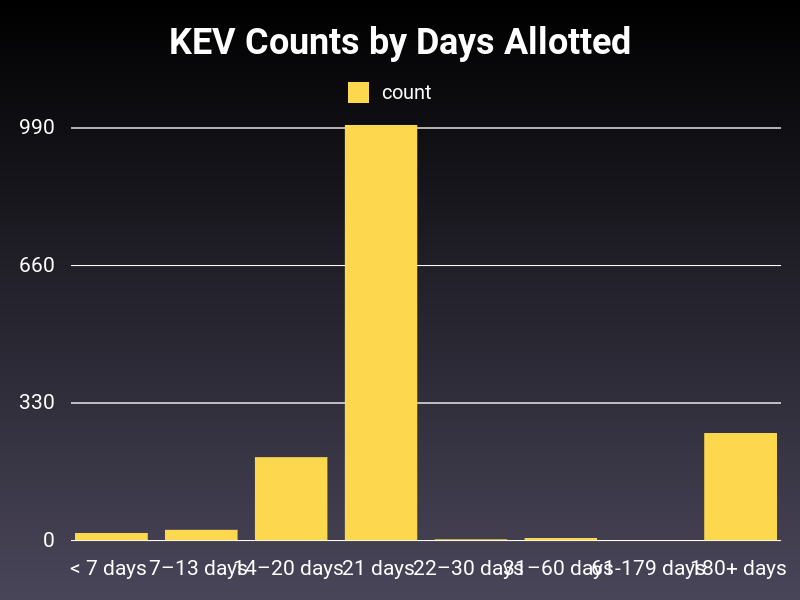

In [4]:
title = "<h1>Figure 1: KEVs by Days Allotted</h1>"
IRuby.display IRuby.html(title)

# Reusable helper to display a Gruff-generated RMagick image inline in Jupyter
def hacky_render(gruff_obj)
  # Gruff::Base subclasses have #to_image which returns an RMagick::Image
  png_data = gruff_obj.to_image.to_blob
  encoded = Base64.strict_encode64(png_data)
  IRuby.html("<img src='data:image/png;base64,#{encoded}' alt='Chart' />")
end

def plot_kev_days_allotted(df)
  # Define buckets as [label, range]
  buckets = [
    ["< 7 days", 0..6],
    ["7–13 days", 7..13],
    ["14–20 days", 14..20],
    ["21 days", 21..21], #lol
    ["22–30 days", 22..30],
    ["31–60 days", 31..60],
    ["61-179 days", 61..179],
    ["180+ days", 180..Float::INFINITY]
  ]

  # Initialize counts
  counts = Hash[buckets.map { |label, _| [label, 0] }]

  # Tally values
  df[:kev_days_allotted].each do |days|
    next if days.nil?

    days = days.to_i
    bucket_label = buckets.find { |_, range| range.include?(days) }&.first
    counts[bucket_label] += 1 if bucket_label
  end

  puts "Counts by bucket: #{counts.inspect}"

  # Build bar chart
  g = Gruff::Bar.new(800)
  g.title = "KEV Counts by Days Allotted"

  labels = counts.keys.each_with_index.map { |k, i| [i, k] }.to_h
  g.labels = labels
  g.data(:count, counts.values)

  hacky_render(g)
end

plot_kev_days_allotted(df)


"<h1>Figure 2: KEVs added by Day of Week</h1>"

{"Monday"=>282, "Thursday"=>295, "Friday"=>167, "Wednesday"=>488, "Tuesday"=>268, "Sunday"=>1}


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlgAAAHCEAYAAABj42snAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAIAASURBVHja7N1lQBVLG8Dx/9KNAgqiAiIKgmLgVewWsbu7u7u7u7sTwe5OTOxAMVFUFBNEQOL9AFzwBRs9eH1+X5Qze2Zm9+zO2Z0z84yCgoISE4MQQgghhBBCCCGEEKmQBo7Y46LqagghhBBCCCGEEEIIkTwNHHGQDiwhhBBCCCGEEEIIkVrFdmDlV3U1hBBCCCGEEEIIIYRIngZOMgJLCCGEEEIIIYQQQqReCtc4rahJEHchhBBCCCGEEEIIkTopRPNG+Uc6sIQQQgghhBBCCCFE6qShOCoyhVAIIYQQQgghhBBCpFqxMbAkiLsQQgghhBBCCCGESKViVyGUEVhCCCGEEEIIIYQQIpXSwBEHRUZgCSGEEEIIIYQQQohUSkZgCSGEEEIIIYQQQohULTYGlnRgCSGEEEIIIYQQQohUKnYVQplCKIQQQgghhBBCCCFSKZlCKIQQQgghhBBCCCFSNQniLoQQQgghhBBCCCFSNYmBJYQQQgghhBBCCCFSNZlCKIQQQgghhBBCCCFStdgOLJlCKIQQQgghhBBCCCFSKUU9q1qY+uWYGFVXRAghhBBCCCGEEEKI5CjqVdVtNDSlA0sIIcTfyeK0uY/5bngcGGDyuEzS9H2r983fdxMqbqw4oVLuP79cVfnd+zvu5Ni7Y1tBn6C+an3mJU2vtL7SuMpOsHfd3oV7/VR9dIT4M+SekXtB7q7QK7iXbq/lUKJriQHFS4H5OfOL5vsgJGNIhpBssOjlwtuL/oEBRQZmHbhE1bUWv4u0u0KIX01iYAnxF3Or4tbIzRx2Ft7ZeMeWpOmbLmw6tNkA6m6sO6lurq/nZ+uZZVuWmXAeH/vzbcHIz+ie0cWk23nP9B7nfRhK3y29t0wXKFOvTOsydp+vR0qZZTYzZlY7yDXFeW6uTlCyWclOJZ2TbrcyaOXtVS7QckrLbi21vr8cnSCdVzpP4MWOFw+eK6D7VDdQ90HS7dqNaNe63XtYErYkYGnZX7ffqqIZovle8w0EHAt49dgMTC6bXDM5npAerR2tHa0HVgWs9K0ewrOizwoGVlVBRV8pdsSeB6+STTdAH2NI8e9LVZWrKr97f30VUywAeJ1suhWZyRZXnpGqD87v97X2Pwk11FCHd1nf2bxzBr/GfnX8+sGhtYcWHroFiz8uerbYDe7Wu1f9Xg9V751IabVy1ypR6w2sybmmxurFoBGi8V7jDXCYE4m3S0Ma0gDWvjanbTIAK37seu78trNWp2Uwfe70rdMdkqaPKDnCYcQKGFVoVJbR8z+fjxKtRCtRELQ16N6LaDD2NfYzPp+Q/r3f9zee3UhzvRxkX5Z9XfaRSdMt3CwyWoRBUL4g55elfv3nkupIuyuE+MWkA0uIv5k1mdH9QroRhqTlqw+UWm+03moFwbo260evewZGfZPvuHpR+EWBF5WhgW2D8IYnINItsnRk42+oR0oxUdKSHja+3tjS8x8oSUlKhifdzL2qe+MKGUBppxRSMkOMWoxajPq3F1OidInqJYqC7iLdErqTkqZH6UfpRRnBlrZbXLdmBvKRm//gja5bfrcybmFgMsukssnipOlq4WrhaqFQv3/9xvWfwXTH6elmqOL76AUvlfgRP0+SSTdAHyNSviNJVeWqyu/e32P4xT1IJc860YNUJlUfHBX43nY3mmiiwAgjjAAXXHABXIa5THABeur31OtpBGNvjs01di2MrDHSddTO728/RepifMvYz9gHFg1ftGShfqKOq6+ISh+VLioTP3w9n+t2dsC5m8BcIJkOLOcFzityDwDOsp6an88nx4wcCxy6g7GvcaixXdL0QgMKjXKtDhTHgcDP56P7TPe57kOwm2bnaTcZWAYk6sB6UO9BjQc9IKhxUN2XH+Ne/C+0299L2l0hxC+mgZMEcRfib6VYkYkIIOozG8R3YH2lnZjQccL48SHgctrlvkuVpOkxWjGaMdrQWL9RQOM1EDA7YHNA7e+oR0oxIS3msJnNrza7wyydWToz9UEtTC1M7X3CZum8051NtwPyu+Y3drkP5+aem3j+6LcXU6lSpQYVA4FLyT6mc2jfIa9Db+Gl7kv/lyt+8T6rUKOMjXI2WvAN26VrlL3RBZjuNN18hiq+j54SyJ0vpBugrxgRex0s/Q+Uqyq/e3/NOEnazycrVmQiG3AOB35gpOWfLqXbXfX36qHq72AIQxgC5L6X+0KeTlDvYb1D9brBR+OPhh9NVL3X4nu5FXAr5/YBjEYbVTRKZipgYNnAEoH1YOCggc0HvQC/Tn6tbk+CENsQ65DjwEj6s/77y720/vKSyzfhY9qPEz62A83Xmm80nyek556Qe6ZzG6Azxcny+XxcR7lOKdQ47o/TSdOzLcq2KtsQMJ1v2s60Ebws8DLfy3JJt8s5J+dSp16gFqYWrpZMeWdWnJl99iJwgx00/20fT+oj7a4Q4heTEVhC/M2syEzQF9INvzwCq5pZ1exVL0OXkC7tunT+fDbDRg1rPywEDnY7dPOQL/D/v6d+pR6nPU4vPe0Hk5tNKj/55I/v7t0O9+zuzYTn7Z+3eO4Fx/Idq33MI24kVjLbu5dzr+VuAOcczzmc/4520v0f97LuWz6f7qnrGepVO+64Dv/x/UmtDG8Z3jG8AFVyVClU+TkQwNMvbZ+3V96heStCjqE5qucoADcH3uxx83fGTPHnCTe/kB4/tc0uhb8vVVWuqvzu/TXDlNAvpCeeymKm6oOjAt/Z7ipRSpQSCekOpz+e3hPK5itbquwHqGlQ06rGSSCKKCIT3l/Vtmq+Kg9h6PShY4f4wpCJQ7oM/fjVWolUxnae7VbbVoA9FUmmXR7bc2y9cXdhRaEVtiuWARc4/G9ifIyjH7iewwkn3AUuT7k86nJ5yE/+T35Hs11hu952DBh2MyxtuASC7YPtgvMlzadQg0I1XMsC7nT4UnmFhriOd60NOx7tvLIzmZFaznOdl+buHfeHV9L0c5vPrT73EKiB63+ivf5R0u4KIX4xDcURB0VGYAnxd7JWMnMXIPmB84oRhqQBJfOn7UTmlVbrM4+FJTmW9liyB4ALNE76/t2Bu333OMH4ueMGTLgJygLUFc3vr8fTRk9qP+0NWzNv/bBtz0/s7xZWAyhbQMkPnrs8fbzqxXVgrUy6eUXHioUqvoBRjiMdRn9DO2k/0mGSfVPIsijLyiyLkqZHGUYZRKWBLbe2rNniAf/V9rfmlZrGNQeDToDOU5273/6+RmqNzBruhiGOgx2GWv7GCu/En2VfSNePndqmOGKZop+XqspVld+9v7Ux5fYX0q2VzGQDxZErSlZVHxwV+P52N7b1bkI5gEUsZBFQrkz5DGWfweYMm80324D2U+1A7QcJ+fRb1G9nv/ywxWwLW3PCheU+cy5cRPwhtLtob9OO/nx6YOtnTZ8NA0WH97+inTqX+1z/cxsgf8v8XfInzj+uwzRX51wlc2WCU7u8N5x6kfT9ri1dO7iu+no5rp0K9XEtDjsdd47Zlcz3T+58uWs5ewGe1Eru/WdPnt199iMog2j+n2ivf5S0u0KIX0wDR+W/8cuuEOL7mWCrxP/SGJZM+r8xsBRrXEAjWCNE4zWsDV/rsaYNpDmX5kKaXknf5t/Ov5n/aGju0WxQs+MQUwSnmMoASorUI6Vsdti8d/NAmKk3U3eGIaiFqn1QC05Iz984f/v8zpCe9PnS3YLn7i/Kvmjy+fzcc7uvcH/7+fSD9w5ePJQZXrV4VeDVcMBR+eIv03kb5W2bNyd0md3Fq3MuKJ67eIni7yGDV4btGeZClF6UbpQB+Lfyb+w/HI74Hjl9xBRmd5hdfc5F8B3nO9R3U8odr2/
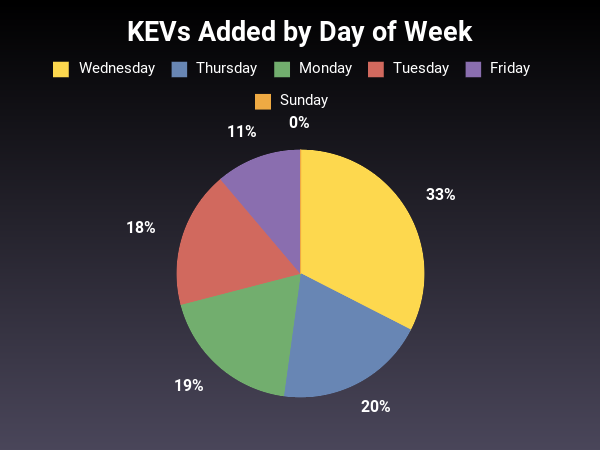

In [5]:

title = "<h1>Figure 2: KEVs added by Day of Week</h1>"
IRuby.display IRuby.html(title)

# Example usage with a pie chart because who doesn't love pie charts.

def plot_kev_days_pie(df)
  day_counts = Hash.new(0)
  df[:kev_day_added].each do |day|
    next if day.nil? || day.to_s.empty?
    day_counts[day] += 1
  end
  return if day_counts.empty?

  # Build pie chart
  g = Gruff::Pie.new(600)
  g.title = "KEVs Added by Day of Week"

  day_counts.each do |day, count|
    g.data(day, count)
  end

  puts day_counts.inspect
  hacky_render(g)
end

plot_kev_days_pie(df)

In [6]:
# KEVs with a Friday add that have a short deadline
mask =
  df[:kev_day_added].eq('Friday') &
  df[:kev_days_allotted].lt(21)

filtered = df.where(mask)

result = filtered[
  :cve_id,
  :kev_vulnerability_name,
  :cvss_base_severity,
  :kev_days_allotted,
  :kev_date_added
]

result = result.sort([:kev_date_added], ascending: false)

title = "<h1>Friday KEVs with Short Deadlines (&lt;21 days), #{result.size} total</h1>"
table_html = result.to_html
IRuby.html("#{title}#{table_html}")


,cve_id,kev_vulnerability_name,cvss_base_severity,kev_days_allotted,kev_date_added
1350,CVE-2025-14733,WatchGuard Firebox Out of Bounds Write,CRITICAL,7,2025-12-19
1463,CVE-2025-55182,Meta React Server Components Remote Code Execution,CRITICAL,7,2025-12-05
1482,CVE-2025-64446,Fortinet FortiWeb Path Traversal,CRITICAL,7,2025-11-14
1372,CVE-2025-22457,"Ivanti Connect Secure, Policy Secure, and ZTA Gateways Stack-Based Buffer Overflow",CRITICAL,7,2025-04-04
1240,CVE-2024-3400,Palo Alto Networks PAN-OS Command Injection,CRITICAL,7,2024-04-12
1210,CVE-2024-21762,Fortinet FortiOS Out-of-Bound Write,CRITICAL,7,2024-02-09
940,CVE-2022-24682,Synacor Zimbra Collaborate Suite (ZCS) Cross-Site Scripting,MEDIUM,14,2022-02-25
920,CVE-2022-22620,"Apple iOS, iPadOS, and macOS Webkit Use-After-Free",HIGH,14,2022-02-11
911,CVE-2022-21882,Microsoft Win32k Privilege Escalation,MEDIUM,14,2022-02-04
706,CVE-2021-20038,SonicWall SMA 100 Appliances Stack-Based Buffer Overflow,CRITICAL,14,2022-01-28


In [7]:
title = "<h1>Table 3: Short Deadlines</h1>"
IRuby.display IRuby.html(title)

subset =
  df
    .where(df[:kev_days_allotted].lt(7))
    .dup

# Sort by urgency (fewest days allotted first)
subset = subset.sort([:kev_days_allotted])

# Classify straight-shot RCE
subset[:straight_shot_rce] =
  subset.map_rows do |row|
    row[:cvss_attack_vector] == 'NETWORK' &&
      row[:cvss_privileges_required] == 'NONE' &&
      row[:cvss_user_interaction] == 'NONE' &&
      row[:cvss_confidentiality_impact] == 'HIGH'
  end

# Final table
subset[
  :cve_id,
  :kev_date_added,
  :kev_day_added,
  :kev_days_allotted,
  :kev_vendor_project,
  :cvss_base_severity,
  :straight_shot_rce
]


"<h1>Table 3: Short Deadlines</h1>"

,cve_id,kev_date_added,kev_day_added,kev_days_allotted,kev_vendor_project,cvss_base_severity,straight_shot_rce
1354,CVE-2025-20333,2025-09-25,Thursday,1,Cisco,CRITICAL,false
1357,CVE-2025-20362,2025-09-25,Thursday,1,Cisco,MEDIUM,false
1450,CVE-2025-49704,2025-07-22,Tuesday,1,Microsoft,HIGH,false
1451,CVE-2025-49706,2025-07-22,Tuesday,1,Microsoft,MEDIUM,false
1455,CVE-2025-53770,2025-07-20,Sunday,1,Microsoft,CRITICAL,true
1464,CVE-2025-5777,2025-07-10,Thursday,1,Citrix,CRITICAL,true
1212,CVE-2024-21893,2024-01-31,Wednesday,2,Ivanti,HIGH,true
1488,CVE-2025-7775,2025-08-26,Tuesday,2,Citrix,CRITICAL,true
1500,CVE-2026-24858,2026-01-27,Tuesday,3,Fortinet,CRITICAL,true
945,CVE-2022-26134,2022-06-02,Thursday,4,Atlassian,CRITICAL,true


In [8]:
title = "<h1>Finding: KEVs by DoW</h1>"
IRuby.display IRuby.html(title)

# Total number of KEVs
total = df.nrows.to_f

# All days of the week
weekdays = %w[Monday Tuesday Wednesday Thursday Friday Saturday Sunday]

# Build rows
rows = weekdays.map do |day|
  count = df.where(df[:kev_day_added].eq(day)).nrows
  [day, count, (count / total).round(4)]
end

# Weekend total
weekend_count = df.where(df[:kev_day_added].in(%w[Saturday Sunday])).nrows
rows << ["Weekend (Sat+Sun)", weekend_count, (weekend_count / total).round(2)]

# US holidays
holiday_count = df.where(df[:kev_holiday].eq(true)).nrows
rows << ["US Holiday", holiday_count, (holiday_count / total).round(2)]

# Create Daru DataFrame
table = Daru::DataFrame.rows(
  rows,
  order: [:Day, :Count, :Percent]
)

table


"<h1>Finding: KEVs by DoW</h1>"

,Day,Count,Percent
0,Monday,282,0.1879
1,Tuesday,268,0.1785
2,Wednesday,488,0.3251
3,Thursday,295,0.1965
4,Friday,167,0.1113
5,Saturday,0,0.0
6,Sunday,1,0.0007
7,Weekend (Sat+Sun),1,0.0
8,US Holiday,0,0.0


"<h1>Figure 2: KEVs by DoW</h1>"

Counts by weekday: {"Monday"=>282, "Tuesday"=>268, "Wednesday"=>488, "Thursday"=>295, "Friday"=>167, "Saturday"=>0, "Sunday"=>1}


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYEAYAAADK5l4zAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAIAASURBVHja7N1nYFRV1Lf9fwqQAiFA6L1Il15UelFAQaoIAgIiIohUQcECogIivUhREFCRjiAdaSJIF4TQe+8hEEggJPN+mGe/cz/JnWcmIclJhuv3ZYyc2WftM5OTmbPOXsvD9n8IAAAAAAAAAADATXhaHQAAAAAAAAAAAEBiIwECAAAAAAAAAADcDgkQAAAAAAAAAADgdkiAAAAAAAAAAAAAt0MCBAAAAAAAAAAAuB0SIAAAAAAAAAAAwO2QAAEAAAAAAAAAAG6HBAgAAAAAAAAAAHA7JEAAAAAAAAAAAIDbIQECAAAAAAAAAADcDgkQAAAAAAAAAADgdkiAAAAAAAAAAAAAt0MCBAAAAAAAAAAAuB0SIAAAAAAAAAAAwO2QAAEAAAAAAAAAAG6HBAgAAAAAAAAAAHA7JEAAAAAAAAAAAIDbIQECAAAAAAAAAADcDgkQAAAAAAAAAADgdkiAAAAAAAAAAAAAt0MCBAAAAAAAAAAAuB0SIAAAAAAAAAAAwO2QAAEAAAAAAAAAAG6HBAgAAAAAAAAAAHA73lYHAAAAAAAA8LSuX79+/fp16cKFCxcuXJDCw8PDw8OlbNmyZcuWTSpSpEiRIkUkb29vb2+uhgAA8ExgBQgAAEgylSpVqlSpkuTh4eHh4RH348qVK1euXJl64zt//vz58+el11577bXXXpMCAgICAgKkAgUKFChQQJo4ceLEiRMtexlSfbxIncLCwsLCwpz/fpnHiIiIiIgIq6MGkBpERUVFRUVJU6ZMmTJlilSyZMmSJUtKOXLkyJEjh1SlSpUqVapItWrVqlWrllSiRIkSJUo4EiCAFfi7CADW4J4HAACAp9SuXbt27dpJ27dv3759u+P/379///79+1Lv3r179+7tuPDy6quvvvrqq8QLAEB8PHz48OHDh1Ljxo0bN24sbd68efPmza4/Pzo6Ojo62upZAACA5MQKEADPjIYNGzZs2ND5nTZ9+vTp06dPwvdz8+bNmzdvSnny5MmTJ4/rd/gMGzZs2LBhCY87qR+nTZs2bdo0xx3jrj7v7NmzZ8+eTfzX87333nvvvfdcj2Pr1q1bt25NtrebywYNGjRo0CDn8XMBOmUyd+bt2LFjx44dzrf/888///zzT+IFkPSe9vND2rRp06ZN6ygdVK1atWrVqkn9+/fv37+/6+cRIDF98MEHH3zwQfwTH0Zil75as2bNmjVrnP8+pU+fPn369AlPwPTq1atXr17O93Pu3Llz587Ff/zJkydPnjzZ+fjly5cvX7584h0/AACSAwkQAEgk5guNubP68uXLly9fdv48cwfb559//vnnn1s9C+fatGnTpk0b17dfvXr16tWrEz8O84XTmVy5cuXKlUuqUaNGjRo1ku84OWPeL7/++uuvv/7qfPv169evX79eunbt2rVr16yOHoaPj4+Pj4+UOXPmzJkzO9/evB+dSaoSCUkVLwD3ExkZGRkZ6bixwyQ8xo4dO3bsWEdCpGrVqlWrVpX++uuvv/76y+qo4a5OnTp16tQpae7cuXPnzk34OImdAHnhhRdeeOEFx9/juDx48ODBgwfSyZMnT548Gf/9uJpw/Oeff/7555/4j3/w4MGDBw863878vgMAkJqQAAGARPLll19++eWX0oYNGzZs2OB8e1Na5ueff/7555+df3FKKZo2bdq0aVPHhVRnEjsBYr6gXbp06dKlS863f+ONN9544w3J09PT0zMF/dUzdy5evHjx4sWLzrc3ta5dTZggeX333Xffffed5OXl5eXlFfvfTe1xs3LJaqktXgAp1+7du3fv3i3Vrl27du3a0uDBgwcPHizZbDabzWZ1dHAXq1atWrVqlfMVFObz9Lfffvvtt986bkgyCb2dO3fu3Lkz8eLKlClTpkyZpOeee+65555zvv2BAwcOHDjg+vim5JerCYqkToCYhA8AAKlJCroUBACpk7kz/+uvv/7666+db+/n5+fn5yctXbp06dKlUmBgYGBgoNWzcJ1pltyoUaNGjRo5395c6A8PDw8PD3/6/ZsvwK6K74qV5JLQOxjnzJkzZ84cq6NHTJ07d+7cubN0+PDhw4cPSzNnzpw5c6a0bNmyZcuWSf/++++///7r+P2xWmqLF0DKZxIeI0aMGDFihPT++++///77VkcFd3Hs2LFjx44538587hs4cODAgQMdKxnNyg9XV0DGl6uJgfgmQHbt2rVr1y7pyZMnT548cb59fBMgJqFkPg8k1jwBAEhJaIIOAAlkViCYkleu1vQ1Fxqff/75559/PvHiqVu3bt26dR0rHhJbzZo1a9as6fj5zTfffPPNNx0XTONiEh8mEfK0vSxcXVFSoECBAgUKpLwvaqYEgkmAxdehQ4cOHTrk+AJdrly5cuXKWT0rGMWLFy9evLjjMaVLbfECSHxxfX4wpfWuXLly5coVaePGjRs3bpT279+/f/9+5+POmDFjxowZjs87PXv27Nmzp9WzRWoVGhoaGhrqfDurPheZz5vObnCJbwIkvr12zPhm5Yi58SouJ06cOHHihPMblcxKl2LFihUrViy5jioAAImDBAgAxJNZQt+6devWrVtLt27dunXrlvPn9e3bt2/fvkm3IsFcYEiuOy6bNGnSpEkTyd/f39/f33FhPy4mcZHQBMidO3fu3LnjeukCk6BJaUziw/R4SCizEoQECADgacT384Mp9dmhQ4cOHTpI169fv379etzbf/LJJ5988omjhGbevHnz5s1r9ayR2rh6o1HatGnTpk2b/PEl1QqQ7du3b9++3fXtzUqRvXv37t27N/YNTDG5WvqqSpUqVapUST0lewEA+J8ogQUA8TRgwIABAwa4vsS8Vq1atWrVkkaNGjVq1Ciro0885o4y08TdmaftBbJ27dq1a9c6emE4k1JLX5meL3ExPRmyZcuWLVu2uLebN2/evHnzXC+JkFDr1q1bt26dI+GXL1++fPnyOXrA5MiRI0eOHFLLli1btmwpbd26devWrcl3PFNKfDGboMb1+Pvvv//++++xn1+6dOnSpUs7tsuQIUOGDBlc37+vr6+vr2/s/Znfm8SO11WmJM4ff/zxxx9/OFbMmVrpJoFq4jevnzmvTJ48efLkyQlPGJqSKc7m2bZt27Zt2zqeZ+40Hj58+PDhwx1NX7NkyZIlSxYpXbp06dKlc8Rr5rVv3759+/Y9/fvJnOfMCjsTn+kdlT59+vTp0zviyJ49e/bs2R0Xuj777LPPPvtMOn369OnTp58+nuRm7kju2rVr165dHSv6zO+1OT+a+U6aNGnSpEnSo0ePHj165Hz8mBfy4npM6N+RDz744IMPPnA+fmq9k/rll19++eWXpU2bNm3atMn5HebmBglTGiuhTBNs83tZo0aNGjVqOBIq5vchY8aMGTNmdPQy6tKlS5cuXeLfpP1Zf59Ydf42JWVjHocFCxYsWLDA+fPNDUdxHc/E7gFilClTpkyZMo7jEpdr165du3bNeeLQHP+Exuvq95Tk6v1hfv/M76NZeRrX+8jcaGVWkrl6fneXuOLL/N13dj4xj7169erVq5fVUQNAMrIBwDOiQYMGDRo0MO04437s3bt37969Yz9/8eLFixcvdv5885g7d+7cuXPbbPYvOtbFndTsKxpcPy5Hjx49evRo/Pdj/+LtfHz7hYLkPw7O2Jtw2mz2Zuxxx1+nTp06derYbPYv8M7na78wkXhxPn78+PHjx64f77geBw0aNGjQIJutYsWKFStWTLx5pNT47BfInY9jv6Ad+/mlSpUqVapUwucT1+OaNWvWrFmT+PE6ExwcHBwc7PrxdfYYFBQUFBRks/3222+//fa
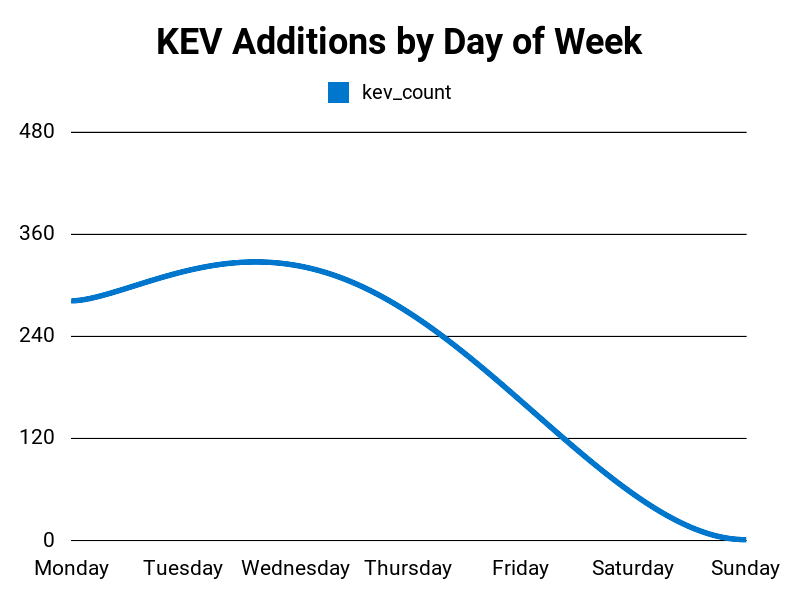

In [9]:
title = "<h1>Figure 2: KEVs by DoW</h1>"
IRuby.display IRuby.html(title)

def plot_kev_weekday_bezier(df)
  weekdays = %w[Monday Tuesday Wednesday Thursday Friday Saturday Sunday]
  counts = weekdays.map { |day| df.where(df[:kev_day_added].eq(day)).nrows }

  puts "Counts by weekday: #{weekdays.zip(counts).to_h.inspect}"

  g = Gruff::Bezier.new(800)
  g.title = "KEV Additions by Day of Week"
  g.labels = weekdays.each_with_index.map { |day, i| [i, day] }.to_h
  g.data(:kev_count, counts)
  g.theme = {
    colors: ['#0077cc'],       # blue line
    marker_color: 'black',
    background_colors: 'white'
  }

  hacky_render(g)
end

plot_kev_weekday_bezier(df)


"<h1>Figure 3: KEVs by Ransomware</h1>"

"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfQAAAF3EAYAAAADYmW/AAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAGYPSURBVHja7d1nYBTl/vbxa1NISAKh916kN0EQkF4FAQFRRBGRJlIUVFDsBVERRUUU5CAgipWiSJGmIoj0DqFL7z0hCUnmebHnfvac5L+HEJLcm+T7ebOQzM5eO9mdmd/cZVzOvwkAAAAAAFjjZzsAAAAAAACgQAcAAAAAwCdQoAMAAAAA4AMo0AEAAAAA8AEU6AAAAAAA+AAKdAAAAAAAfAAFOgAAAAAAPoACHQAAAAAAH0CBDgAAAACAD6BABwAAAADAB1CgAwAAAADgAyjQAQAAAADwARToAAAAAAD4AAp0AAAAAAB8AAU6AAAAAAA+gAId+B9+/vnnn3/+WSpUqFChQoWkokWLFi1aVFq2bNmyZctspwMAAACQmaR6gT548ODBgwdLLpfL5XJ5Htu2bdu2bdsbP3/btm3btm2TQkNDQ0NDk66nUqVKlSpVki5fvnz58mXvr3erj4cOHTp06JDUtGnTpk2bJv19yZIlS5YsefPbZ8uWLVu2bPH+uu++++67776b+ts/tbZHVvP++++///770qlTp06dOiUdP378+PHj0ocffvjhhx/aTpfx3OznMyAgICAgQMqbN2/evHmlxo0bN27cWPrggw8++OAD6dq1a9euXbP9rgAg7Xjbb+bOnTt37tzS6dOnT58+nfz1VaxYsWLFiknXN378+PHjx9t+txkHxzMAacVnWtBNwd21a9euXbtKUVFRUVFRnt/nzJkzZ86c0ty5c+fOnev5f1p78MEHH3zwwaQ/P3z48OHDh6XNmzdv3rw5+ev76aeffvrpp6Q/NzvwBx544IEHHkj795VR7N69e/fu3d4PeHFxcXFxcWn3+s2bN2/evHnSnzdr1qxZs2a2t07mFx8fHx8fL50/f/78+fPSypUrV65cKQ0fPnz48OFSzZo1a9asKR09evTo0aO20wJA+rl48eLFixelZ5555plnnrGdBjfC8QxAcgXYDmA8+uijjz76qLR37969e/d6fm4KsRkzZsyYMUOqUKFChQoVbrw+0yW5SZMmTZo0ufk8pgX/vvvuu++++6QhQ4YMGTJEun79+vXr1z3LmS7QZsd6I94K9AYNGjRo0CDlLfPptT2ympdeeumll16S7r333nvvvddzBdz05EDq8Pb5jImJiYmJkXbs2LFjx46k+4c9e/bs2bNH6t27d+/evaUlS5YsWbLE9rsBgPTz5Zdffvnll1Lfvn379u3raZmFHRzPANwq6wW66dI9Z86cOXPmJP29KZA6derUqVOn5K+3Ro0aNWrUkL755ptvvvnm1nO2bNmyZcuW0sKFCxcuXOj5uSm4TU5vTNfoDRs2bNiwIenvvbXUp5bU3h6Zlelilj179uzZs3t+Xq1atWrVqtlOl3nd6PPpOI7jONKwYcOGDRuWdIjB0qVLly5dKh05cuTIkSNS8eLFixcvbvtdARmbt/0hfNPAgQMHDhzo6dkXGBgYGBhoO1XWw/EM8D0Z7XhmrYv7b7/99ttvv0mjRo0aNWpU0t936NChQ4cO0quvvvrqq6/a20CGtwLaFNwnTpw4ceKE9+eblnazYzb8/f39/f2l+++///7777f9LpPP2xg2M8Z+3Lhx48aNkypXrly5cmUpKCgoKChIKliwYMGCBaX+/fv379/fM7QhsWLFihUrVuzGLdXmBMS8/tWrV69ever5/Z133nnnnXcmzWmGSvTq1atXr16eIRNmEjjDtEgkfr4Ze3Yjf/zxxx9//CF16dKlS5cunvWb7WF6TAwYMGDAgAHSP//8888//9x4vQcOHDhw4IDUp0+fPn36eNaTLVu2bNmyed5PvXr16tWr5xlbGBsbGxsb63295sq+2e5mjOOkSZMmTZqU3p8yD7PdR4wYMWLECO/L7d+/f//+/Ul/bobMjBkzZsyYMVLt2rVr167t2U5mh23e9wsvvPDCCy9IV65cuXLlivfXS+vvQXr93RP75ZdffvnlF6l9+/bt27eXihQpUqRIEU/+EiVKlChRwtPSY4ai3Ii376P5npi8VatWrVq1qhQcHBwcHOxpkTLfu8jIyMjISOnSpUuXLl2SnnrqqaeeespzImu2R+nSpUuXLi298sorr7zyiqeLqWGelziP+ZwkZroUm540ZvnnnnvuueeeS7q8GYITEhISEhLiWd7s9y9cuHDhwoX0+7ze6v4wsbTav91Ix44dO3bsmPR9mALVG1P4JH6e2Z6Jt196fd9Sy86dO3fu3OmZOyWtpNX+Ib33p7ZwPHPjeMbxjOPZ/+CkskGDBg0aNMiUoJ7HNm3atGnTxnFOnjx58uRJx3F/oZMud9ttt912222O4/7g3PrrpRb3Dsdx3B+kpK/nLmC8P79du3bt2rVL+5zptT3cQw2Svo67pTnpz709mu2SmPuLkfz1mEf3F9qzHveOPely7klakv48X758+fLl8zzffeBIupzZzt64d0SO495hJD9/njx58uTJ4zibNm3atGlT0vX+/ffff//9t+PkyJEjR44cN7996tevX79+fcdxX0lMun73UI6kz8ufP3/+/Pntfz7dPVG8v7/E28194cyzX7nZ7VWlSpUqVap43x+l9fcgvf7uxpNPPvnkk0/e/PrNftF9YPS+fm/fR2/b0duju0eV41SvXr169erJf97TTz/99NNPe/KYvImXcx+gk+b/7rvvvvvuu6TLu0/Aki5vPo+Jl69Vq1atWrWSLp/Wn9db3R8aabV/Sy53l+6k63efwHp/nnusdtLnuYcwpf/3Lbm87TfNfjnxz91D0hzHfQKZdH3evm/uycq850jr/UN67U9TC8ezlG1/jmf//cjxLGWf18xyPPMm3Qr01q1bt27d2vOY+Pfmi+q+Anzrr1eqVKlSpUp5PsDJfXSPEfL+eu4x6Ulf75577rnnnnuSLu++MuY47itnSZ83bdq0adOmpf32T+3tcaMdkHtIgOO4rzQ5jvvKmPflIyIiIiIiPOtftGjRokWLHGfChAkTJkzw/rwff/zxxx9/dBz3EAnHcV/h86zH2xfYPPr5+fn5+TmOu8XecdxXhj3Pv9kC3T1mzPvruSeXc5zHH3/88ccf974d3VeyHcd9hdSz/jp16tSpUyfp8t26devWrZvjLFiwYMGCBZ4LRu4W8KTLv/POO++8807S/NOnT58+fXrS5d1XntPu83mjExqzHYYOHTp06NCkz8+VK1euXLk83zejR48ePXr08H4hcPLkyZMnT3acsWPHjh071nHcV1qTLv/yyy+//PLL6f89SK+/u7eCxzy6x7Q6jrtHieOUKVOmTJky3k9s3Hd9SPo6N/o+tmjRokWLFo7jbolxnPLly5cvX/7GB0qznfv169evXz/HcV/pTrqc+8q/47iv6DuO+4q/Zz9glnO3qCTN725h8Z7DPXmoZ3nz90i8nHtSqKTrT+vP663uD9N6/5Zc5oK5u2Uj+d8jb4XGV1999dVXX6Xf9+1m3Wi/2b179+7du9/4woNxswV6eu0f0mt/mlo4nnE843jG8exWj2fepFuB7u6K7H1DlCtXrly5cjd/xdnb66X0MXELbGI//PDDDz/84P2LnHiHagrHxMubgt3dpSXtt39qbw9vH1R315Sky5vtYq44JX7erFmzZs2alfR5u3bt2rVrl/d87kn7vG8Pb19gdxcbx3GP8fL+/Jst0M0XOvHy5kCcmLkAYr7giZ/n7pLpWd7dlSjpcu5ZX5Ou/9NPP/30008dxz1ZjefRPWeC9/e9du3atWvXOo57aMaNL1zd6ufT3eXLcdx3MfA8du7cuXPnzp79g7fPgbkCmtjtt99+++23ew5w5tE9xCbp8q+//vrrr7+edP3
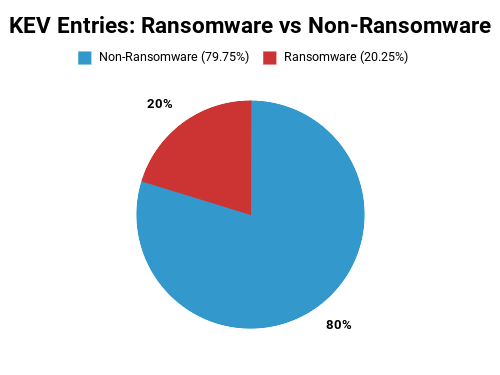

In [10]:

title = "<h1>Figure 3: KEVs by Ransomware</h1>"
IRuby.display IRuby.html(title)

total = df.nrows.to_f
ransomware_count = df.where(df[:kev_ransomware].eq(true)).nrows
non_ransomware_count = total - ransomware_count
ransomware_label = "Ransomware (#{(ransomware_count / total * 100).round(2)}%)"
non_label = "Non-Ransomware (#{(non_ransomware_count / total * 100).round(2)}%)"

g = Gruff::Pie.new(500)
g.title = "KEV Entries: Ransomware vs Non-Ransomware"

g.data(ransomware_label, ransomware_count, '#cc3333')      # red
g.data(non_label, non_ransomware_count, '#3399cc')         # blue

g.theme = {
  marker_color: 'black',
  background_colors: 'white'
}

hacky_render(g)


"<h1>Figure 4: KEVs by CVSS Severity</h1>"

KEV Entries by CVSS Base Severity:
NONE: 0 (0.0%)
LOW: 9 (0.6%)
MEDIUM: 237 (15.79%)
HIGH: 763 (50.83%)
CRITICAL: 491 (32.71%)


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfQAAAF3EAYAAAADYmW/AAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAG3dSURBVHja7d13fBTV/v/xd0ISCL1XQTpKERBUil2pIggIKiKIIKIoggXsFDuKKCoCAlJUEOGCSBNRREWRJgpI773XQBKSzO+Pvec392bvftP3zCav5+PhYyWZ2XnvZKd85pw5E+b8mwAAAAAAgDXhtgMAAAAAAAAKdAAAAAAAPIECHQAAAAAAD6BABwAAAADAAyjQAQAAAADwAAp0AAAAAAA8gAIdAAAAAAAPoEAHAAAAAMADKNABAAAAAPAACnQAAAAAADyAAh0AAAAAAA+gQAcAAAAAwAMo0AEAAAAA8AAKdAAAAAAAPIACHQAAAAAAD6BAB5Djffvtt99++61UunTp0qVLS+XKlStXrpz0ww8//PDDD7bT2deoUaNGjRpJYWFhYWFh7uv48ePHjx9vOx0AILvhuIycjAId6fL4448//vjj/ifsLVu2bNmyZcrzr1+/fv369VK+fPny5cvn/z5XXnnllVdeKZ09e/bs2bOBl5fR1927d+/evVu6+eabb775Zv/fX3755Zdffnna189ff/31119/BV7u8OHDhw8fnvnrP7PWR07z3nvvvffee9KRI0eOHDkiHTx48ODBg9IHH3zwwQcf2E4Hr/jpp59++uknqXPnzp07d5aqVKlSpUoVKU+ePHny5JGKFi1atGhRqWnTpk2bNpXefffdd999Vzp//vz58+cDv6/X9j/bt2/fvn279NRTTz311FNSnTp16tSpIxUqVKhQoUJS3rx58+bN637+nj179uzZU1q1atWqVavSnjfYy0tJWvevuXPnzp07t1S2bNmyZcu6x8EJEyZMmDBBSkhISEhIyPycSB2vfb+QOhyXkaM5QDr07du3b9++jmO+Rea1RYsWLVq0CDzfmTNnzpw54zjVqlWrVq2a//wFCxYsWLCg42zevHnz5s0pLy+jr7t27dq1a5fjjBkzZsyYMYGn+/PPP//888/Ur59hw4YNGzbM/318J3SO4yuEM3/9Z9b6CLZNmzZt2rQpcK5Lly5dunQp65Yf6O/lO0EI/vrwmuuuu+66667zXz+ffvrpp59+ajtd1omPj4+Pj3ec3r179+7dO/3bVcWKFStWrOg4GzZs2LBhg/9yvLL/GT169OjRox0nMjIyMjIy7Z/TvP/LL7/88ssvp5wz2MtLrczev/p6oDiO74Jzpn9NEYBXv19InbQel22fRwCZKUJAED344IMPPvigtG3btm3btrk/Ny0RU6ZMmTJlilSjRo0aNWqk/H6m69NNN9100003pT2PacG/++677777bumJJ5544oknJN+O3J3OdLWqV69evXr1Un7fuXPnzp071//nTZo0adKkSfpbxoK1PnIa3wmYdNddd911111SRERERESE25MDOdPAgQMHDhwojRs3bty4cf6/r169evXq1d1X09Kzdu3atWvXSomJiYmJiW7PFN8FTGnjxo0bN250W/Bs739+++233377TXrssccee+wx//mKFy9evHhx6dZbb7311lulXLly5cqVS/r1119//fVXad++ffv27TMX/KVXX3311Vdfdbef++6777777rO3vMwSaP9qekisW7du3bp10oEDBw4cOOD+fsWKFStWrHBzZrQHFf5vofr9wn/juIwczfYVAoSmtLagv/3222+//XbgK5uvvPLKK6+8knnLS69WrVq1atXKfzkNGzZs2LBhyvP7TszcK+/J3+ejjz766KOPgr/+vS7YV74vXLhw4cIF2586dOS0FnRfge044eHh4eHh/p/b13U98Py+LuaO4yvA/ecfOnTo0KFD/eeztf/p0aNHjx49/Kf3XSh1ez4lFxsbGxsb6zjNmjVr1qyZ//xXX3311VdfbX95aZXe/avZTwX6O5qeY8haXv9+4X/L6HGZFnRkJ9yDjixl7tl84YUXXnjhBf/f33nnnXfeeac0ZMiQIUOG2E4b+Mr4mjVr1qxZIx06dOjQoUOB5zctXb7Ny/25uUJv7l0NFVdcccUVV1zhf8+lucd1xIgRI0aMkGrWrFmzZk33XsxSpUqVKlVK8nUNdscSSO6yyy677LLLUr4i7uui6C4/+T29gQYxmzNnzpw5c6Tu3bt3795d8t1C4Q42Y/Tq1atXr17+85t7UVPy888///zzz1KHDh06dOjgvr9ZH6bF8pFHHnnkkUekPXv27NmzJ+X33blz586dO917Is37REVFRUVFuZ/HV0BL77///vvvvy/5umZn/fcjJiYmJiZG6t+/f//+/aUyZcqUKVPGvSe7du3atWvXlj788MMPP/xQSkpKSkpK8n+fBg0aNGjQwH/9m/UVyPz58+fPn+8/n9nezD2LaTVp0qRJkyb5523cuHHjxo2lp59++umnnw48/1VXXXXVVVe5LeLJzZ49e/bs2f4/t7X/MS3/yZl76c33LDnz/Tb39taqVatWrVruayDBXl6wmBa+9u3bt2/f3v/3p0+fPn36dOD5fQWK9Oabb7755pvudmHWR3R0dHR0tLu/fPHFF1988UXp3Llz586dSzlfsPYnWbU/TC3b36/M+vxt27Zt27at//7t0UcfffTRRwMvf8mSJUuWLPGfz3x/An1fMvvvFqzjckbPI7x2/AEk0YKO9EmpheHw4cOHDx92HF+h5j+dr0uo4/hOWDK+vMxi7hH0Hcj8lzd27NixY8cGnr9169atW7fO+pzBWh+mxSH5cnyD7KT+Xj6zXpLzHZDTfm+g7wTDfZ9ALbzFihUrVqyY/899XRzd+X0nrP7TmfUciO9EOnCLZaBX32Bige8t/uOPP/744w/HKVCgQIECBdK+fnyFpONcvHjx4sWLGf8eBFq/vsGVUp+rT58+ffr08X9/X5df/+l9g245jq9Q9p/PvF/y+XxdkNP/eQONkWH+3qnlGwzTcXyFlPtq7q1Mztb+57nnnnvuuef85zM9AL7//vvvv/8+o98ie8tLq4zuXwcMGDBgwAD/+X2DAfpP77vw4h4X07q9+wrIwMfTYO1Psmp/mFa2vl+Z/fmnTp06depU/+krVapUqVKlwDmeeeaZZ555xn8+X1fx4P3dgnVczuh5hNeOP4DjOA4FOtIl0AlM8+bNmzdv7r4m/705Qfjnn3/++eefjC/PDL7ka9FK/WtcXFxcXFzg5fnuCfVfXps2bdq0aeM/va8l0XF8LYf+8/la5LJ+/Wf2+ghUoJvX22+//fbbb3cc35Vmx/FdwQ48/ZYtW7Zs2eK+/6JFixYtWuR2vQ0036xZs2bNmuU4vpZHx/GNiuy+T6ATAfNquir7rrQ7jq/F350/rQW6OcELtLxbbrnllltucQ/ggdajr4eC4/juVXbf33RpTj59p06dOnXq5DgLFixYsGCBW7AVKVKkSJEi/tObW0syKqX1e8MNN9xwww2O8/DDDz/88MPu+g00/bJly5YtW+a+v68lJvAJ4urVq1evXu2fy/w9k09vBodKr0Db8ddff/31119nfH2mJNj7H19Lj+OUKFGiRIkSKQ925usR4c6XVsFeXloF2r/6eka4hZN59Y1R4Di+Fj/H8bWgufOZQcqWLl26dOlS/+V16dKlS5cugS9km/d/55133nnnHXcw1eTTB7pVLKv3J1m9P/T69yurPr+5YOdrwU75eGoEuoD+xRdffPHFF8H7uwXruJzR8wivHX8Ax6FARzoFOoFJabTUqlWrVq1aNe0te5k9qm7yFtjkZs6cOXPmTP/5TMuWOSE2zA4/+fTmhDnQPW+Zvf4ze30EOiCblsDkzHoxV9aTzzdt2rRp06b5z5fRe8cCnQj4uq45jm/Qn8Dzp7VANycuyafv169fv379/Kc3F0DMiUzy+XxdEt3
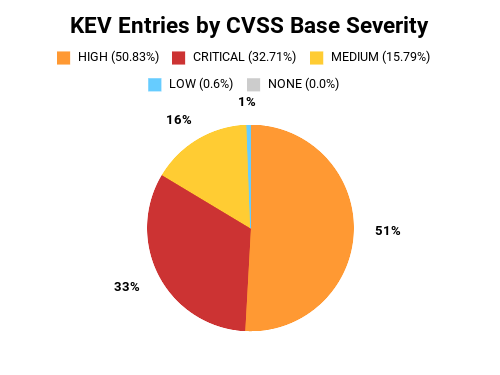

In [11]:
title = "<h1>Figure 4: KEVs by CVSS Severity</h1>"
IRuby.display IRuby.html(title)

# Count CVEs by severity
severity_buckets = %w[NONE LOW MEDIUM HIGH CRITICAL]

counts = severity_buckets.each_with_object({}) do |sev, h|
  h[sev] = df.where(df[:cvss_base_severity].eq(sev)).nrows
end

total = df.nrows.to_f

# Compute percentages
percentages = counts.transform_values { |c| (c / total * 100).round(2) }

# Print counts and percentages
puts "KEV Entries by CVSS Base Severity:"
severity_buckets.each do |sev|
  puts "#{sev}: #{counts[sev]} (#{percentages[sev]}%)"
end

# Build labels including percentages
labels = counts.map do |sev, count|
  label = "#{sev} (#{percentages[sev]}%)"
  [label, count]
end.to_h

# Optional colors for pie slices
colors = ['#cccccc', '#66ccff', '#ffcc33', '#ff9933', '#cc3333'] # None→Critical

# Create the pie chart
g = Gruff::Pie.new(500)
g.title = "KEV Entries by CVSS Base Severity"

# Add each slice with explicit color
labels.each_with_index do |(label, count), idx|
  g.data(label, count, colors[idx])
end

# Theme tweaks
g.theme = {
  marker_color: 'black',
  background_colors: 'white'
}

hacky_render(g)


In [12]:
exact_impact_mask = df[:cvss_confidentiality_impact].eq('NONE') &
                    df[:cvss_integrity_impact].eq('NONE') &
                    df[:cvss_availability_impact].eq('HIGH')

exact_impact_df = df.where(exact_impact_mask)

matching_count = exact_impact_df.nrows
total_count = df.nrows
percentage = (matching_count.to_f / total_count * 100).round(2)

title = "<h1>Finding: KEVs by Ransomware</h1>"
IRuby.display IRuby.html(title)

puts "CVEs with C:N, I:N, A:H: #{matching_count} / #{total_count} (#{percentage}%)"

ransomware_count = exact_impact_df.where(exact_impact_df[:kev_ransomware].eq(true)).nrows
ransomware_percentage = (ransomware_count.to_f / matching_count * 100).round(2)

puts "Of these, ransomware-tagged: #{ransomware_count} / #{matching_count} (#{ransomware_percentage}%)"


"<h1>Finding: KEVs by Ransomware</h1>"

CVEs with C:N, I:N, A:H: 47 / 1501 (3.13%)
Of these, ransomware-tagged: 3 / 47 (6.38%)


In [13]:
# Filter for exact impact AND ransomware
subset = df.where(
  df[:cvss_confidentiality_impact].eq('NONE') &
  df[:cvss_integrity_impact].eq('NONE') &
  df[:cvss_availability_impact].eq('HIGH') &
  df[:kev_ransomware].eq(true)
)

# Keep only desired columns
ransomware_df = subset[
  :cve_id,
  :kev_vendor_project,
  :cvss_vector_string
]

title = "<h1>Table 4: DOS Ransomware KEVs</h1>"
IRuby.display IRuby.html(title)

ransomware_df


"<h1>Table 4: DOS Ransomware KEVs</h1>"

,cve_id,kev_vendor_project,cvss_vector_string
274,CVE-2017-10271,Oracle,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H
505,CVE-2019-2725,Oracle,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H
873,CVE-2021-41379,Microsoft,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:H/E:U/RL:O/RC:C


In [14]:
all_cwes = df.map_rows do |row|
  cwe_str = if row[:cve_cwes] && !row[:cve_cwes].empty?
              row[:cve_cwes]
            else
              row[:kev_cwes] || ''
            end
  # Split on '|' and reject empty strings
  cwe_str.split('|').reject(&:empty?)
end.flatten

cwe_counts = all_cwes.each_with_object(Hash.new(0)) { |cwe, h| h[cwe] += 1 }
cwe_df = Daru::DataFrame.new({
  cwe: cwe_counts.keys,
  count: cwe_counts.values
})

cwe_df = cwe_df.sort([:count], ascending: false)

title = "<h1>Finding: CWEs by Count</h1>"
IRuby.display IRuby.html(title)

cwe_df

"<h1>Finding: CWEs by Count</h1>"

,cwe,count
0,CWE-20,114
6,CWE-787,97
23,CWE-78,97
14,CWE-416,86
2,CWE-119,80
7,CWE-22,69
27,CWE-502,58
4,CWE-94,56
9,CWE-843,36
3,CWE-264,31


In [15]:
# Count occurrences of each vendor/project
counts = df[:kev_vendor_project].to_a.compact.each_with_object(Hash.new(0)) do |vp, h|
  h[vp] += 1
end

# Convert to Daru::DataFrame
vendor_df = Daru::DataFrame.new({
  kev_vendor_project: counts.keys,
  count: counts.values
})

# Sort descending by count
vendor_df = vendor_df.sort([:count], ascending: false)

title = "<h1>Finding: KEVs by Vendor</h1>"
IRuby.display IRuby.html(title)

vendor_df

"<h1>Finding: KEVs by Vendor</h1>"

,kev_vendor_project,count
1,Microsoft,353
25,Apple,86
2,Cisco,83
6,Adobe,76
36,Google,67
7,Oracle,42
4,Apache,38
80,Ivanti,30
73,VMware,26
16,D-Link,25


{"CWE-20"=>114, "CWE-787"=>97, "CWE-78"=>97, "CWE-416"=>86, "CWE-119"=>80, "CWE-22"=>69, "CWE-502"=>58, "CWE-94"=>56, "CWE-843"=>36, "CWE-264"=>31, "CWE-287"=>31, "CWE-284"=>30, "CWE-122"=>30, "CWE-306"=>30, "CWE-79"=>29, "CWE-77"=>26, "CWE-89"=>24, "CWE-200"=>23}


"<h1>Figure 5: Top CWEs in the KEV</h1>"

CWE-20,114
CWE-787,97
CWE-78,97
CWE-416,86
CWE-119,80
CWE-22,69
CWE-502,58
CWE-94,56
CWE-843,36
CWE-264,31
CWE-287,31
CWE-284,30
CWE-122,30
CWE-306,30
CWE-79,29
CWE-77,26
CWE-89,24
CWE-200,23


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+gAAALuEAYAAABtHeAOAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAIAASURBVHja7P13fBTV2/j/X5CEkJBCExCB0IsQegtdCFWwUAQ1BqQXRfRNEUWQDgICivQWim8RFARUepUWgggCoUsNIBBIIKEEsr8/9j6/87039352NtnNJpvX85957GTKmdnJ7uxc57pONtP/EAAAAAAAAAAAAAAAsrDsrm4AAAAAAAAAAAAAAAAZAQF0AAAAAAAAAAAAAACEADoAAAAAAAAAAAAAACJCAB0AAAAAAAAAAAAAABEhgA4AAAAAAAAAAAAAgIgQQAcAAAAAAAAAAAAAQEQIoAMAAAAAAAAAAAAAICIE0AEAAAAAAAAAAAAAEBEC6AAAAAAAAAAAAAAAiAgBdAAAAAAAAAAAAAAARIQAOgAAAAAAAAAAAAAAIkIAHQAAAAAAAAAAAAAAESGADgAAAAAAAAAAAACAiBBABwAAAAAAAAAAAABARAigAwAAAAAAAAAAAAAgIgTQAQAAAAAAAAAAAAAQEQLoAAAAAAAAAAAAAACICAF0AAAAAAAAAAAAAABEhAA6AAAAAAAAAAAAAAAiQgAdAAAAAAAAAAAAAAARIYAOAAAAAAAAAAAAAICIEEAHAAAAAAAAAAAAAEBECKADAAAAAAAAAAAAACAiBNABAAAAAAAAAAAAABARAugAAAAAAAAAAAAAAIgIAXQAAAAAAAAAAAAAAESEADoAAAAAAAAAAAAAACJCAB0AAAAAAAAAAAAAABEhgA4AAAAAAAAAAAAAgIgQQAcAAAAAAAAAAAAAQEQIoAMAAAAAALitxMTExMREV7cCAADANu5bAGQUBNABAAAAAADcxKNHjx49eiQyZMiQIUOGiJQvX758+fIiz549e/bsmatbBwAAkNK5c+fOnTsnEhQUFBQUJDJz5syZM2eKJCcnJycnu7p1ALIiAugAAAAAAACZ3NmzZ8+ePStSq1atWrVqiUydOnXq1KkiV69evXr1qsimTZs2bdrk6lYCAACkFBERERERIXLnzp07d+6IDBo0aNCgQSLNmzdv3ry5ng8A6YUAOgAAAAAAQCb1999///333yINGzZs2LChyMmTJ0+ePJlyuWXLli1btszVrQUAuNqxY8eOHTsm0qpVq1atWonky5cvX758IgULFixYsKBIhw4dOnToIHLx4sWLFy+6urVwdyaTyWQyiSxfvnz58uUp/75jx44dO3aINGrUqFGjRiLXr1+/fv26q1sNICsggA7AsPPnz58/f14kW7Zs2bJlS/00LCwsLCzMdcfx888///zzz2k/jhEjRowYMcLV7wqyGkf9Hzp7+sYbb7zxxhuuPlsAkPWoB1D79+/fv3+/yNChQ4cOHSrStGnTpk2bihQpUqRIkSIiuXLlypUrl4i3t7e3t7dIoUKFChUqJFKxYsWKFSuKdOnSpUuXLiLffvvtt99+K3LhwoULFy6kvX2XLl26dOmS/d8rqoRjWh0/fvz48ePG99u1a9euXbumfb+PHz9+/PixiKenp6enp/H9qxLcljLL/YCabtu2bdu2bWk/j/jfLl++fPnyZZHQ0NDQ0FCRf//9999//7W+vPr/z6qePn369OlT/Xuwe/fu3bt3F6latWrVqlVF8uTJkydPHhEvLy8vLy+RgICAgIAAXUq2WbNmzZo1Exk+fPjw4cNFDhw4cODAAVcflcjBgwcPHjwo8vnnn3/++eciISEhISEhut0+Pj4+Pj76eEqXLl26dGmRFi1atGjRQmTatGnTpk1z3Oc8gIxLVSRp3Lhx48aNRTZv3rx582aR2NjY2NhY/T2iPiebNGnSpEkTkfv379+/f9/VrYe7UkPMVK5cuXLlytaXi46Ojo6O1t9fcXFxcXFxrm49ALdmAgCDzGPRmEzq0yO1U/MDW5Pp4cOHDx8+TP/jMPekTftxmB9QuPpdQVbjqP9DZ09ff/31119/3dVnCwCyjh9++OGHH34wmcxjHTv+cz179uzZs2c3mdq1a9euXTuTKTIyMjIyMvXtNQfsje/fHMhO+3maPXv27Nmzje+3ZMmSJUuWTPt+1fmy97z/9NNPP/30U8rtZZb7ATXdunXr1q1b034eYZaYmJiYmGgymR802z7/Y8aMGTNmjKtbnf6eP3/+/Plzk2nOnDlz5swxmQoXLly4cGHHX9/VqlWrVq2aybRv3759+/Y5/7jMFQZMJnNJW8cdh4eHh4eHh8nUt2/fvn37mkzmUrmufhcBONKECRMmTJhg/+fDkiVLlixZ4urWw90lJSUlJSWZTJ06derUqZPt69LcgVB/3wOAo5GBDiDdJSQkJCQkiPzyyy+//PJL+u03Pj4+Pj5e5Ndff/31119dfRaQ3tatW7du3Tr7M6bMHT1c3XoAgFFZ5fNejQFoDmjrjPHTp0+fPn3a8ftLTk5OTk4W2bBhw4YNG0Tq1atXr149kVGjRo0aNUpnjhilMiSNOnr06NGjR9N+HH/88ccff/xhfHlVuvTGjRs3btxI/X5T2357zxOyhmHDhg0bNkxXVLAmPDw8PDxc5Isvvvjiiy9c3er0ozIp1Zip/fr169evn0hMTExMTIzj96f+v1UJfZXR7WiqkoMa497cMcVx2zcHIETmzp07d+5ckTp16tSpU0dXOgDgeOl935raMaQZexrpQVVqUmOhV6lSpUqVKtaXV9+LU6ZMmTJliqtbD8AdEUAH4DIrV65cuXJl+u1PlaBSJTQBAAAyGxXIVYGajRs3bty4Mf3boQLm5sxWXepcBdptqVu3bt26dY3v79SpU6dOnRJ58uTJkydPUt9uc4Zo+q2n2BtAV6WXX3zxxRdffDH1+4V7UR1AZs2aNWvWLOvLlSpVqlSpUiLz5s2bN2+eq1udflQpVzVkhRozNb2oz7/BgwcPHjxYZPHixYsXL077dlWp+LZt27Zt21bEXIHA+cejSrqrMWfv3bt379495+8XgPOktmMeHfqQntTQIz/++OOPP/4okiNHjhw5clhfXnUUVCXeAcBRCKADcJktW7Zs2bIl/Xqyfv/9999//72rjxoAAMB+qgNg69atW7du7bxM89RS91kff/zxxx9/bHt5ex/EqoD9iRMnTpw4YX/7rl+/fv369dRnUtqbuW7J3gA6D6rx/2UuICjyySeffPLJJ/q1NTNmzJgxY4ZIzpw5c+bM6erWp5/evXv37t1b5NixY8eOHXN1a/T7ldrfu2rM9h49evTo0SPtHYhS68qVK1euXDH++Q4g4+rYsWPHjh1FwsLCwsLCrC+nMt2HDh06dOhQkfr169evX9/VrUdWU7Zs2bJly4p8+OGHH374ofXlzKXfRQYNGjRo0CBXtxqAO/F0dQMAZF3qQajqUdi/f//+/fs7fj+3bt26detW+mcgABlJ9+7du3fvLvLmm2+++eabzt+feWxbVx81ALgPldGY2sBQiRIlSpQoIfLaa6+99tprOkPVz8/Pz89PlzxWJaFVqXZ7Mw6//fbbb7/9VqRz586dO3fWpd4t1axZs2bNmiJeXl5eXl76wZctf/31119//SVSo0aNGjVqGG9XWgPgqV1fZaT+/ffff//9t/H1nBVAT+/7AaVq1apVq1ZNv/25G1VJ6/Dhw4cPH7a+XIMGDRo0aKAzlbMKVcpc/a40ytvb29vbWz9wV4Gll1566aWXXhK5ffv27du39dBjkyZNmjRpkvEMcJURr0qijxgxYsSIEcbbp9azN6NOlXgfPnz48OHDdQlcFZDfs2fPnj17RL788ssvv/zS+BAVqqSuCmTY+zkMIONYvnz58uXLRfr06dOnTx/9/ZI9e/bs2bPrSkfVq1evXr26q1uLrE5lmKvKOtaGMFCJWtu3b9++fbtIs2bNmjVr5ur
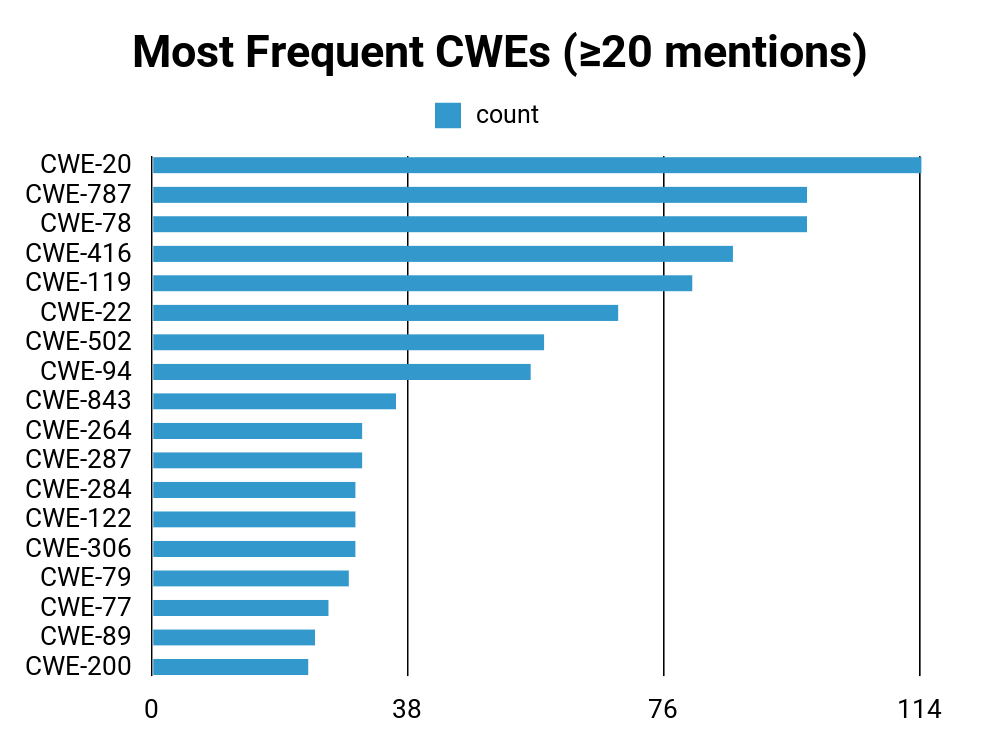

In [16]:
# Filter CWEs with count >= 20
top_cwes = cwe_df.where(cwe_df[:count].map { |c| c >= 20 })

# Build a hash CWE ID => count
cwe_counts = top_cwes[:cwe].to_a.zip(top_cwes[:count].to_a).to_h

# For Gruff, labels need integer keys (position on axis) => label text
labels = {}
cwe_counts.keys.each_with_index { |cwe, i| labels[i] = cwe }

counts = cwe_counts.values

puts cwe_counts.inspect   # CWE => count mapping

g = Gruff::SideBar.new(1000)
g.title = "Most Frequent CWEs (≥20 mentions)"
g.labels = labels
g.data(:count, counts)

g.theme = {
  colors: ['#3399cc'],
  marker_color: 'black',
  background_colors: 'white'
}

title = "<h1>Figure 5: Top CWEs in the KEV</h1>"
IRuby.display IRuby.html(title)

puts cwe_counts.map {|k,v| [k, v].join(',')}
hacky_render(g)


In [17]:
all_cwes = df.map_rows do |row|
  cwes = row[:cve_cwes].to_s.strip
  cwes = row[:kev_cwes].to_s.strip if cwes.empty?
  cwes.split('|')
end.flatten.compact

unique_cwes = all_cwes.uniq

title = "<h1>Finding: All CWEs mentioned</h1>"
IRuby.display IRuby.html(title)

puts "Total CWEs observed: #{all_cwes.size}"
puts "Unique CWEs: #{unique_cwes.size}"

unique_cwes


"<h1>Finding: All CWEs mentioned</h1>"

Total CWEs observed: 1426
Unique CWEs: 170


["CWE-20", "CWE-120", "CWE-119", "CWE-264", "CWE-94", "CWE-399", "CWE-787", "CWE-22", "CWE-77", "CWE-843", "CWE-189", "CWE-310", "CWE-601", "CWE-79", "CWE-416", "CWE-255", "CWE-200", "CWE-125", "CWE-362", "CWE-191", "CWE-352", "CWE-284", "CWE-269", "CWE-78", "CWE-254", "CWE-287", "CWE-19", "CWE-502", "CWE-88", "CWE-190", "CWE-89", "CWE-611", "CWE-704", "CWE-326", "CWE-434", "CWE-552", "CWE-281", "CWE-522", "CWE-388", "CWE-732", "CWE-285", "CWE-749", "CWE-80", "CWE-36", "CWE-415", "CWE-404", "CWE-59", "CWE-74", "CWE-134", "CWE-521", "CWE-122", "CWE-306", "CWE-798", "CWE-863", "CWE-918", "CWE-807", "CWE-295", "CWE-91", "CWE-288", "CWE-917", "CWE-178", "CWE-1188", "CWE-347", "CWE-330", "CWE-706", "CWE-73", "CWE-131", "CWE-665", "CWE-427", "CWE-400", "CWE-23", "CWE-121", "CWE-697", "CWE-755", "CWE-1285", "CWE-667", "CWE-1173", "CWE-390", "CWE-782", "CWE-470", "CWE-95", "CWE-138", "CWE-912", "CWE-425", "CWE-39", "CWE-862", "CWE-193", "CWE-497", "CWE-823", "CWE-790", "CWE-1220", "CWE-1390", 

In [30]:
# This uses net/http. Might be risky. Uncomment cwe_df lines if you actually want this to run.

require 'net/http'
require 'uri'
require 'openssl'

def fetch_cwe_ids
    
cwe_ids = ["CWE-120", "CWE-20", "CWE-119", "CWE-264", "CWE-94"] # etc.

counts = Hash[cwe_ids.map { |cwe| [cwe, 1] }] # replace 1 with real counts if you have

results = []


cwe_ids.each do |cwe|
  number = cwe.split('-').last
  url = URI("https://cwe.mitre.org/data/definitions/#{number}.html")
  puts "Fetching #{cwe} from #{url}..."

  begin
    # Setup HTTP request
    http = Net::HTTP.new(url.host, url.port)
    http.use_ssl = true
    http.verify_mode = OpenSSL::SSL::VERIFY_NONE # skip SSL verification
    http.open_timeout = 5
    http.read_timeout = 5

    req = Net::HTTP::Get.new(url)
    res = http.request(req)

  if res.is_a?(Net::HTTPSuccess)
    # Extract title
    title_match = res.body.match(/<title>\s*([^\(]*)/im)
    desc = title_match ? title_match[1].strip : "N/A"

    # Strip the leading "CWE - " if present
    desc = desc.sub(/^CWE\s*-\s*/, '')
  else
    desc = "Error: #{res.code} #{res.message}"
  end


  rescue => e
    desc = "Error: #{e.class} #{e.message}"
  end

  results << { cwe_id: cwe, count: counts[cwe], desc: desc }
end
results
end

title = "<h1>Finding: CWE name mappings</h1>"
warning = "<b><p>Note, this depends on an external HTTP call to the CWE people.</p></b>"
IRuby.display IRuby.html(title+warning)

# Uncomment this to actually run the net/http connections
# results = fetch_cwe_ids

cwe_df = Daru::DataFrame.new(results)
cwe_df


"<h1>Finding: CWE name mappings</h1><b><p>Note, this depends on an external HTTP call to the CWE people.</p></b>"

,cwe_id,count,desc
0,CWE-120,1,CWE-120: Buffer Copy without Checking Size of Input
1,CWE-20,1,CWE-20: Improper Input Validation
2,CWE-119,1,CWE-119: Improper Restriction of Operations within the Bounds of a Memory Buffer
3,CWE-264,1,"CWE-264: CWE CATEGORY: Permissions, Privileges, and Access Controls"
4,CWE-94,1,CWE-94: Improper Control of Generation of Code


In [31]:
target_cwes = %w[CWE-521 CWE-1393 CWE-259]

rows =
  df.map_rows do |row|
    cwes = row[:cve_cwes].to_s.strip
    cwes = row[:kev_cwes].to_s.strip if cwes.empty?

    match = cwes.split('|').find { |cwe| target_cwes.include?(cwe) }
    match ? [row[:cve_id], row[:kev_vulnerability_name], match] : nil
  end.compact

title = "<h1>Table 6: Sample bottom CWEs</h1>"
IRuby.display IRuby.html(title)

rows.each {|r| puts CSV.generate_line(r)}


"<h1>Table 6: Sample bottom CWEs</h1>"

CVE-2019-18988,TeamViewer Desktop Bypass Remote Login,CWE-521
CVE-2022-28810,Zoho ManageEngine ADSelfService Plus Remote Code Execution,CWE-259
CVE-2023-45249,Acronis Cyber Infrastructure (ACI) Insecure Default Password,CWE-1393


[["CVE-2019-18988", "TeamViewer Desktop Bypass Remote Login", "CWE-521"], ["CVE-2022-28810", "Zoho ManageEngine ADSelfService Plus Remote Code Execution", "CWE-259"], ["CVE-2023-45249", "Acronis Cyber Infrastructure (ACI) Insecure Default Password", "CWE-1393"]]

In [32]:
# Select only rows with EPSS scores
epss_df = df.where(df[:epss_today])

# Sort descending by EPSS score
top_epss = epss_df.sort([:epss_today], ascending: false)

# Take the top 10 and select columns of interest
top_epss_view = top_epss[
  :cve_id,
  :kev_vendor_project,
  :kev_vulnerability_name,
  :epss_today,
  :epss_percentile
].head(10)

# Compute average EPSS
average_epss = epss_df[:epss_today].mean

puts "Average EPSS across all KEVs: #{average_epss.round(4)}"

median_epss = epss_df[:epss_today].median
puts "Median EPSS: #{median_epss.round(4)}"

title = "<h1>Table 7: Top EPSS Scores</h1>"
IRuby.display IRuby.html(title)

top_epss_view


Average EPSS across all KEVs: 0.5613
Median EPSS: 0.7292


"<h1>Table 7: Top EPSS Scores</h1>"

,cve_id,kev_vendor_project,kev_vulnerability_name,epss_today,epss_percentile
1221,CVE-2024-27198,JetBrains,JetBrains TeamCity Authentication Bypass,0.94579,1.0
1052,CVE-2023-23752,Joomla!,Joomla! Improper Access Control,0.94517,1.0
272,CVE-2017-1000353,Jenkins,Jenkins Remote Code Execution,0.94508,1.0
407,CVE-2018-7600,Drupal,Drupal Core Remote Code Execution,0.94489,0.99999
737,CVE-2021-22986,F5,F5 BIG-IP and BIG-IQ Centralized Management iControl REST Remote Code Execution,0.94485,0.99999
1104,CVE-2023-35078,Ivanti,Ivanti Endpoint Manager Mobile Authentication Bypass,0.94482,0.99998
364,CVE-2018-13379,Fortinet,Fortinet FortiOS SSL VPN Path Traversal,0.94475,0.99998
507,CVE-2019-3396,Atlassian,Atlassian Confluence Server and Data Center Server-Side Template Injection,0.94471,0.99998
203,CVE-2016-10033,PHP,PHPMailer Command Injection,0.9447,0.99997
505,CVE-2019-2725,Oracle,"Oracle WebLogic Server, Injection",0.9447,0.99997


In [33]:
# Select only rows with EPSS scores
epss_df = df.where(df[:epss_today])

# Sort descending by EPSS score
bottom_epss = epss_df.sort([:epss_today], ascending: true)

# Take the top 10 and select columns of interest
bottom_epss_view = bottom_epss[
  :cve_id,
  :kev_vendor_project,
  :kev_vulnerability_name,
  :epss_today,
  :epss_percentile
].head(10)

title = "<h1>Table 8: Bottom EPSS Scores</h1>"
IRuby.display IRuby.html(title)

bottom_epss_view

"<h1>Table 8: Bottom EPSS Scores</h1>"

,cve_id,kev_vendor_project,kev_vulnerability_name,epss_today,epss_percentile
1436,CVE-2025-43529,Apple,Apple Multiple Products Use-After-Free WebKit,0.00025,0.0602
1089,CVE-2023-32373,Apple,Apple Multiple Products WebKit Use-After-Free,0.00042,0.12712
1148,CVE-2023-42916,Apple,Apple Multiple Products WebKit Out-of-Bounds Read,0.00047,0.14415
795,CVE-2021-30762,Apple,Apple iOS WebKit Use-After-Free,0.00049,0.15098
1124,CVE-2023-37450,Apple,Apple Multiple Products WebKit Code Execution,0.00054,0.16953
1149,CVE-2023-42917,Apple,Apple Multiple Products WebKit Memory Corruption,0.00068,0.20946
1069,CVE-2023-28205,Apple,Apple Multiple Products WebKit Use-After-Free,0.0007,0.21599
1366,CVE-2025-21479,Qualcomm,Qualcomm Multiple Chipsets Incorrect Authorization,0.00074,0.22575
1051,CVE-2023-23529,Apple,Apple Multiple Products WebKit Type Confusion,0.0008,0.23695
1216,CVE-2024-23296,Apple,Apple Multiple Products Memory Corruption,0.00082,0.24276


In [34]:
no_cwe_df =
  df.where(
    df.map_rows do |row|
      cve_cwes = row[:cve_cwes].to_s.strip
      kev_cwes = row[:kev_cwes].to_s.strip
      cve_cwes.empty? && kev_cwes.empty?
    end
  )

no_cvss_df =
  df.where(
    df.map_rows do |row|
      cve_cvss = row[:cvss_base_score].to_s.strip
      cve_cvss.empty?
    end
  )

title = "<h1>Finding: KEVs with no CVSS scores: #{no_cvss_df.nrows}</h1>"
IRuby.display IRuby.html(title)
puts "KEVs with no KEV-defined CWE IDs: #{no_cwe_df.nrows}"

no_cvss_df = no_cvss_df.sort([:kev_date_added], ascending: false)
no_cvss_df[:cve_id, :kev_vulnerability_name]

"<h1>Finding: KEVs with no CVSS scores: 1</h1>"

KEVs with no KEV-defined CWE IDs: 166


,cve_id,kev_vulnerability_name
0,CVE-1969-1234,FakeCorp FakeApp Test


0.0,355
0.1,92
0.2,68
0.3,58
0.4,57
0.5,43
0.6,56
0.7,78
0.8,145
0.9,548


"<h1>Figure X: KEV EPPS Score Distribution</h1>"

[[0.0, 355], [0.1, 92], [0.2, 68], [0.3, 58], [0.4, 57], [0.5, 43], [0.6, 56], [0.7, 78], [0.8, 145], [0.9, 548]]


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYEAYAAADK5l4zAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAH3HSURBVHja7N13nFT1vT/+90qvQkQjGFEQFSFSBFFDsQeNQbBLjDGKYlSioKKoWBJrkFgSC2CNvWCuYo2xFyJYURFBBZMIVkAMCIIwvz/mnt+53+XunV3Y3dk9+3w+Hj7GYc+c+Zz39PP6lJLcfwsAAAAAAICM2KDYDQAAAAAAAKhsAhAAAAAAACBzBCAAAAAAAEDmCEAAAAAAAIDMEYAAAAAAAACZIwABAAAAAAAyRwACAAAAAABkjgAEAAAAAADIHAEIAAAAAACQOQIQAAAAAAAgcwQgAAAAAABA5ghAAAAAAACAzBGAAAAAAAAAmSMAAQAAAAAAMkcAAgAAAAAAZI4ABAAAAAAAyBwBCAAAAAAAkDkCEAAAAAAAIHMEIAAAAAAAQOYIQAAAAAAAgMwRgAAAAAAAAJkjAAEAAAAAADJHAAIAAAAAAGSOAAQAAAAAAMgcAQgAAAAAAJA5AhAAqAX++c9//vOf/4zYb7/99ttvv4iWLVu2bNkyYsstt9xyyy0j/vSnP/3pT38qditJVNbjtXTp0qVLl0aUlJSUlJQUvlyxYsWKFSuKffR1j9dntnjdAQBAdpTk/luxGwIAlK1fv379+vWLePnll19++eWyt3v00UcfffTRiJ/97Gc/+9nPit3ququyHq/kRGyLFi1atGhR+H6XL1++fPnyiMaNGzdu3LjYVag7vD6zxesOAACywwgQoMbZZ5999tlnn8I9LkeOHDly5Mh1v58vv/zyyy+/jPjRj370ox/9qPw9PX//+9///ve/X/d2V/XlhAkTJkyYkPZELu/t5s2bN2/evMp/PIcPHz58+PDyt+P5559//vnni//8KuuyYcOGDRs2jNhkk0022WSTiL59+/bt2zfitNNOO+200yKmTp06derUymtv0rO4vPt96qmnnnrqqaqrH/83j1fd4vGGylfTvk9Vdfvq169fv379iNatW7du3TqiZ8+ePXv2jPjNb37zm9/8JuLxxx9//PHHI9asWbNmzZqqq3vyvfjWW2+99dZbIw499NBDDz004sc//vGPf/zj9HtPo0aNGjVqFLHZZpttttlmEb179+7du3fa3r///e9///vfI77//vvvv/9eex03ANQAOYAaZuDAgQMHDkxGppV9ecopp5xyyikV3//q1atXr16dy+29995777134ftJLn/+85///Oc/z+XyP0DXvd1VfXn99ddff/31udxtt9122223lf9211xzzTXXXFP5j2c+YCp8/+3atWvXrl36+BT7+bW+l3369OnTp08ulw901r/dG2200UYbbVT4fi+//PLLL7+86upX1f7zn//85z//KX+d8z2vi93qtVXW45WVehRbVdexrrw+6wqvu+Kqad+nakr7tt1222233TaXe/LJJ5988sn1r/PixYsXL16cy5100kknnXRSLpfv4FF57e3UqVOnTp1yufyJ9rrX3spSV48bACqTESBAnfO73/3ud7/7XdrzqZD8D4OI22+//fbbb0977NV0gwcPHjx4cPmn5Hjssccee+yxyrv/GTNmzJgxI+KTTz755JNPCm9/yCGHHHLIIREbbLDBBhtk4NNp+vTp06dPj9htt9122223iLPPPvvss89OOh5UfH/5E6cR9erVq1ev3tp/32677bbbbrt0xA3F5fGqWzzeQFWbPXv27NmzI/IBTMQVV1xxxRVXVHw/c+fOnTt3bjoi4Nprr7322msjVq5cuXLlyspr74cffvjhhx9G5DscRVx44YUXXnhh9ttbWerqcQNAVahf7AYAVJd8j7mIiy666KKLLiq8fdOmTZs2bRrx17/+9a9//WtEq1atWrVqVeyjKL9kEd5999133333jfiv//qv//qv/yp7+2efffbZZ59N5zJv0qRJkyZN1v3+k7nuy+vwww8//PDDi121ypcEHpdeeumll14asXDhwoULF0ZMnDhx4sSJ5d/P0UcfffTRR0fssssuu+yySzrlzg9+8IMf/OAH6eOcTHlAcXm86haPN1Bdku8VydSb7du3b9++fcTBBx988MEHl327ZMq+ZIrUjz766KOPPqq+dp933nnnnXdeOiXTMcccc8wxx2SnvZWlrh43AFQlAQiQeckIhCOOOOKII44o/xzKN91000033RSx/fbbb7/99pXXnj322GOPPfZIRzxUtgEDBgwYMCC9fthhhx122GGFA5Ak+EiCkPVdpLe8I0q23HLLLbfcMmLnnXfeeeedK78e66qsxyn5YbpgwYIFCxZEPP30008//XTEG2+88cYbbxTe76RJkyZNmpQ+r0aMGDFixIjyt6tz586dO3dOL6nZPF51i8cbqk91f59a19sfcMABBxxwQNnb5af+jPj3v//973//O+Khhx566KGHIj7++OOPP/648P3kp0ZKg9ZmzZo1a9Zs7e3+/Oc///nPf454//3333///cL7TQLbX/ziF7/4xS8ievTo0aNHj3Stkn/961//+te/Ip544oknnngi4qWXXnrppZcK7zc/hW1EfmrZdM2K2t7eylJXjxsAqlSx5+ACKK2y1gDJDxHP5fI9css/F+6oUaNGjRpVvHZXtmXLli1btiyXy/8gLty+ZI7hdZUf4ZDL5aeCKXx/Z5555plnnll99aiqxymZk/uHP/zhD3/4w8L7Tx6P/A/T6jv+ms7c++pRFdSRivB8Ka6a+n2qutqXfH/Njywr//PwhhtuuOGGG8re7w477LDDDjsU3k9+REkulw9gyt/u/KLc5W/v+PHjx48fn532Vpa6etwAUJUyMMs6wP9u9OjRo0ePjvjHP/7xj3/8o/D2u+6666677hoxbty4cePGFbv1lSeZyivpwVXI+q4FkvQwS3o0FpKVqa+SuZOfeeaZZ555Jq17WfLBVDo1ViHJCJlkDZqyLh988MEHH3yw4u1PHq9kpNDQoUOHDh2aroHTvHnz5s2bpz0N80FP2sN17NixY8eOrfhUDT/+8Y9//OMfp+1v0aJFixYtyn/7ZKq20nVInoeJpUuXLl26tHD9fvKTn/zkJz9Jb/fqq6+++uqr6Zo6G2+88cYbb5xun/x7dT9ehcyZM2fOnDkRxx133HHHHZeOtErWBEp6ciaPX9Lj9Lvvvvvuu+/Kfz/vvvvuu+++W/g4N91000033bTix1H6+VHW5VNPPfXUU09V//Oquh/v/Nf3iIcffvjhhx9ORzZuvfXWW2+9ddrzO2l/MjVO8v5/zTXXXHPNNenroaKSHsmFjjN5/0gsWbJkyZIlEZdccskll1wSsdNOO+20004R+cXj0/eVpL3Jcb3++uuvv/76uterulX1665Pnz59+vQpXP91/VxNRhIU2n9+Me5iVzu7GjRo0KBBg3TEaPI5XMjjjz/++OOPl/33WbNmzZo1q/B+xowZM2bMmIgttthiiy22KH+7jzrqqKOOOqr83zefe+655557LjvtrSxZOe7kfS0ZUT9kyJAhQ4ak74vJ9+Tk+2XyPD/yyCOPPPLIiEceeeSRRx6p/PoW+3O0ur+PFvLCCy+88MILEcOGDRs2bFg6grWsOgwaNGjQoEHp+1NFvzcCFE2xExiA0ta3Z93kyZMnT55c/p5N+Tluc7nPPvvss88+K167q1p+LZPy1yX/A6zi95P/IVF4//kTKNVfh+p6nPJrzRS+n/wPwLTHcVnyJwwL7y8fYJS/nTNnzpw5c2Yul58yofzPj7Iu84vY53KnnnrqqaeemsvlfxiVff9du3bt2rXr+t9v6cv8iaD0fsrbo7tLly5dunRJXy8NGzZs2LBh2dvnpzapuseroj3Rb7nllltuuSWXy59Qrnjdktdl/kR34efPO++
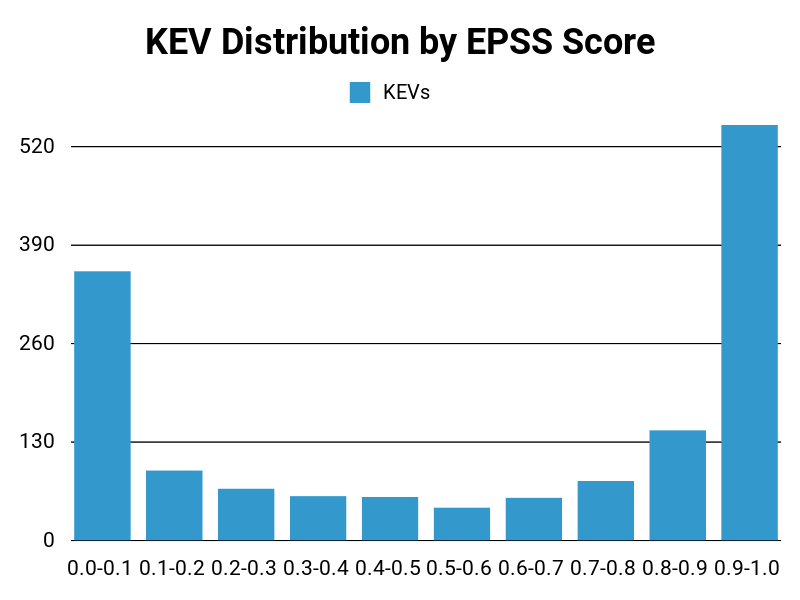

In [35]:
epss_vals = df[:epss_today].to_a.compact
bins = (0..10).map { |i| (i/10.0).round(1) }

epss_counts = Hash.new(0)
epss_vals.each do |v|
  next if v.nil? || v.nan?
  bin = [(v / 0.1).floor * 0.1, 0.9].min
  bin = bin.round(4)
  epss_counts[bin] += 1
end

lines = epss_counts.sort.map { |bin, count| "#{bin},#{count}" }
puts lines.join("\n")

sorted_bins = epss_counts.keys.sort
counts = sorted_bins.map { |b| epss_counts[b] }

g_score = Gruff::Bar.new(800)
g_score.title = "KEV Distribution by EPSS Score"
g_score.labels = sorted_bins.each_with_index.map { |b,i| [i, "#{b}-#{(b+0.1).round(1)}"] }.to_h
g_score.data(:KEVs, counts)
g_score.theme = {
  colors: ['#3399cc'],
  marker_color: 'black',
  background_colors: 'white'
}


title = "<h1>Figure X: KEV EPPS Score Distribution</h1>"
IRuby.display IRuby.html(title)
puts epss_counts.sort.inspect
hacky_render(g_score)


"<h1>Figure 6: KEV EPPS Percentile Distribution</h1>"

[[0.0, 1], [0.1, 4], [0.2, 15], [0.3, 18], [0.4, 17], [0.5, 16], [0.6, 22], [0.7, 67], [0.8, 126], [0.9, 1211], [1.0, 3]]
0.0,1
0.1,4
0.2,15
0.3,18
0.4,17
0.5,16
0.6,22
0.7,67
0.8,126
0.9,1211
1.0,3


"<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYEAYAAADK5l4zAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRP///////wlY99wAAIAASURBVHja7P1pnBTl2T9unwPDNqwqxIBGFlEJKLtwq4DEHRUhLgiJKyokSlREIioa4xKNUZHEBTAKEuOtiIniGg1xQwQUAxgV0EDcQDCIKJvAMM+LST31+8M96QGG6ZnmON70p6D66qurqnuq61vXdeYV/UcAAAAAAADkiCrZ7gAAAAAAAEBZE4AAAAAAAAA5RwACAAAAAADkHAEIAAAAAACQcwQgAAAAAABAzhGAAAAAAAAAOUcAAgAAAAAA5BwBCAAAAAAAkHMEIAAAAAAAQM4RgAAAAAAAADlHAAIAAAAAAOQcAQgAAAAAAJBzBCAAAAAAAEDOEYAAAAAAAAA5RwACAAAAAADkHAEIAAAAAACQcwQgAAAAAABAzhGAAAAAAAAAOUcAAgAAAAAA5BwBCAAAAAAAkHMEIAAAAAAAQM4RgAAAAAAAADlHAAIAAAAAAOQcAQgAAAAAAJBzBCAAAAAAAEDOEYAAUCF89NFHH330UcQJJ5xwwgknRNSrV69evXoRzZo1a9asWcRvf/vb3/72t9nuJYmy2l+rV69evXp1RF5eXl5eXubH9evXr1+/Ptvvftfj85lbfO4AgJ2lrM8b/+d//ud//ud/Mp+vPPHEE0888US23z1QEeUV/Ue2OwLArq1bt27dunWLeP31119//fWS13vmmWeeeeaZiOOPP/7444/Pdq93XWW1v5ILsXXr1q1bt27m1123bt26desiatasWbNmzWxvhV2Hz2du8bkDAHaWsj5vTAKQmTNnzpw5s+T1/vznP//5z3+O6Nu3b9++fbO9FYCKxAgQyILjjjvuuOOOy3wHw6WXXnrppZdu/+t88cUXX3zxRcTee++99957l/5Oz+uvv/7666/f/n7v7McxY8aMGTMmvaOktM9bvHjx4sWLy35/Dho0aNCgQaXvxyuvvPLKK69k//gq6bF69erVq1eP+M53vvOd73wn4rDDDjvssMMihg0bNmzYsIjp06dPnz697Pqb3Flc2nb/+te//vWvf91524//zv7atdjfUPYq2vnUzu5ffn5+fn5+xG677bbbbrtFdOjQoUOHDhE/+clPfvKTn0Q899xzzz33XMTmzZs3b96887Z7cl48YcKECRMmRPTr169fv34RBx544IEHHpie99SoUaNGjRoRe+2111577RXRuXPnzp07p/198cUXX3zxxYhNmzZt2rRJf7dVrh5fgPNGoOISgEAOSk7wf/zjH//4xz+O+Oyzzz777LPMzzvxxBNPPPHEiGuuueaaa67J9rvIrH///v379y/9+s8+++yzzz5b9v1Iflhl0qRJkyZNmkR07969e/fu5bedttXGjRs3btyY/vBOTmDvuOOOO+64Iw1Eunbt2rVr14hXX3311Vdf3f7XS+4o3n333XfffffSb8fKqrJPPbOr7a/KYmcdV/Y3sKMKCwsLCwsjvvrqq6+++ipizpw5c+bMiRg7duzYsWPTO39bt27dunXr9IL9jkpeb8iQIUOGDElvCDr33HPPPffciMcee+yxxx6LePfdd9999930vGfDhg0bNmyIWLJkyZIlSyJmz549e/bstL/HHHPMMcccE/H973//+9//ftldwKts/a0osnV8QWXmvBHY1QhAIAf98pe//OUvf1n6E/yWLVu2bNky4g9/+MMf/vCH9ESnouvTp0+fPn1KPyVHWQcgc+fOnTt3bsSnn3766aefZl7/tNNOO+200yKqVKlSpUoOfPvOmjVr1qxZET179uzZs2fEVVddddVVV0Vs78SKv/nNb37zm99EVK1atWrVqlv/f/LDPRlxQ3bZX7sW+xvY2RYsWLBgwYKIY4899thjj01vvNhWixYtWrRoUToS4u6777777rvToKCsfPjhhx9++GHE0UcfffTRR0fccMMNN9xwQ+73t7Iqq+MLyMx5I1DR5Ge7A0DZeeGFF1544YWIG2+88cYbb8y8fkFBQUFBQcSf/vSnP/3pTxENGjRo0KBBtt9F6SXF1Hr16tWrV690zs+SvPTSSy+99FI6l3mtWrVq1aq1/a+fzFlaWts6YqWySAKPm2+++eabb45YsWLFihUr0jvvSiu5w/GQQw455JBD0pEnyR1EyX5Opnogu+yvXYv9DZSX5LwimXpzn3322WeffSJOPfXUU089teTnJXcoJ1Ok/vOf//znP/9Zfv2+9tprr7322nQqqoEDBw4cODB3+psrtvf4AkrPeSNQ0QhAIAckIxCSKa9KO8ft/ffff//990ccdNBBBx10UNn154gjjjjiiCPSEQ9lrUePHj169EiXTz/99NNPPz1zAJIEH0kQsqNFeks7oqRZs2bNmjVLi7dVFCXtp+QHeTKVwtSpU6dOnRrx9ttvv/3225nbHTdu3Lhx49LjKpnKobRatWrVqlWr9JGKzf7atdjfUH7K+3xqe5//wx/+8Ic//GHJ6yVTFH3yySeffPJJxJNPPvnkk09G/Otf//rXv/6V+XUuuuiiiy66KL1gVrt27dq1a2+93u9+97vf/e53EfPnz58/f37mdpMLbz/60Y9+9KMfRbRv3759+/ZpLYmPP/74448/jnj++eeff/75iGnTpk2bNi1zu5dccskll1ySTi2b1Oqo7P0tbxXt+AK2nfNGoMIoAspd8dDrZJKgkh+Lf5CU3E7x0PiiouI7KzK3lzwOHTp06NCh2et3WVuzZs2aNWuKiop/sGTuX/EPne1/veIRDkVFxUN6M7/eFVdcccUVV5Tf9thZ+6l4hFFR0Z577rnnnntmbj/ZH8U/yMvv/Vd033zzzTfffFP6z2txcJftXtseFZ3tyLZwvGRXRT2fKq/+JeevxXcIl/44vO++++67776S2+3YsWPHjh0zt1N8x39RUfEF8tL3u7gYeen7e9ttt912222509+yUlmPL8glle08oLj2ZOZ+Ft8Qme2tC1REOTALPey6hg8fPnz48Ig33njjjTfeyLz+4Ycffvjhh0fceuutt956a7Z7X3aSqbySO9cy2dFaIMmddckdZ5nkytRXyZzRf/vb3/72t7+l270kxcFUOjVWJskImUxF+J544oknnnhi2/uf7K9kpNCAAQMGDBiQ1sCpU6dOnTp10jssi4Oe9A7EkSNHjhw5ctunqDjwwAMPPPDAtP9169atW7du6Z+fTNW25XZIjsNEaYsZHnrooYceemj6vDfffPPNN99Ma+o0atSoUaNG6frJv5f3/spk4cKFCxcujLjgggsuuOCCdKRVUhMouYM12X/Jnbbffvvtt99+W/rX+cc//vGPf/wj8/v87ne/+93vfnfb38eWx0dJj1sWrS2v46q893fx6WnEU0899dRTT6UjG/fbb7/99tsvvTM36X8ydUny/X/XXXfddddd6edhWyV3Ymd6n8n3R2LVqlWrVq2K+NWvfvWrX/0qoviHesQee+yxxx57pN8rSX+T95UUK64sdvbnrkuXLl26dMm8/bf372pyp3em9g844IADDjgg21s7d1WrVq1atWrpiNHk73Amzz333HPPPVfy/7///vvvv/9+5nZGjBgxYsSIiKZNmzZt2rT0/T777LPPPvvs0p9vvvzyyy+//HLu9Ley2FnHVyavvvrqq6++GnHeeeedd9556R3vJf3d6t27d+/evdN+buv5SXmf95Uk6Xcys0Dfvn379u2b/n1Ifi8k59nJ/jjzzDPPPPPMiKeffvrpp58u66Mge/ulop5H5Op5485S3scNUA6yncDArmhH73yaPHny5MmTS3/HRvHcvkVFn3/++eeff569fu9sxbVMSr9din94bvvrFJ9wZm6/+AJK+W+H8tpPxbVmMr9O8Q+f9E6jkuy
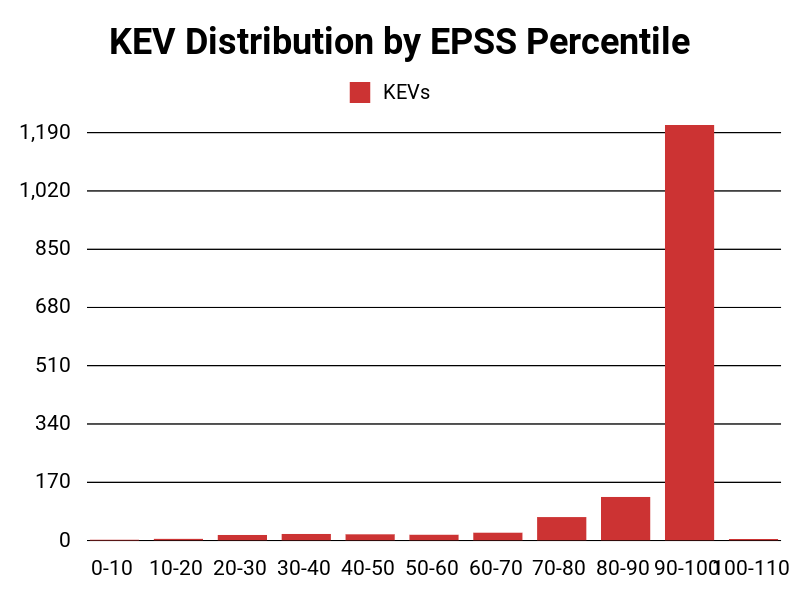

In [36]:

percentile_vals = df[:epss_percentile].to_a.compact
pct_bins = (0..10).map { |i| i / 10.0 }

pct_counts = Hash.new(0)
percentile_vals.each do |v|
  bin = pct_bins.select { |b| v >= b }.max
  pct_counts[bin] += 1
end

sorted_pct_bins = pct_counts.keys.sort
pct_counts_arr = sorted_pct_bins.map { |b| pct_counts[b] }

g_pct = Gruff::Bar.new(800)
g_pct.title = "KEV Distribution by EPSS Percentile"
g_pct.labels = sorted_pct_bins.each_with_index.map { |b,i| [i, "#{(b*100).to_i}-#{((b+0.1)*100).to_i}"] }.to_h
g_pct.data(:KEVs, pct_counts_arr)
g_pct.theme = {
  colors: ['#cc3333'],
  marker_color: 'black',
  background_colors: 'white'
}

title = "<h1>Figure 6: KEV EPPS Percentile Distribution</h1>"
IRuby.display IRuby.html(title)

puts pct_counts.sort.inspect

lines = pct_counts.sort.map {|bin, count| "#{bin},#{count}"}
puts lines.join("\n")

hacky_render(g_pct)

In [37]:
# Only KEVs with Metasploit modules
df_with_ms = df.where(df[:has_metasploit].eq(true))

# Total number of KEVs with modules
total_kevs_with_modules = df_with_ms.nrows

title = "<h1>Finding: Metasploitable KEVs</h1>"
IRuby.display IRuby.html(title)

puts "Total KEVs with Metasploit modules: #{total_kevs_with_modules}"

# Count modules by prefix
prefix_counts = { 'exploits' => 0, 'auxiliary' => 0, 'post' => 0 }

df_with_ms[:metasploit_modules].each do |mods|
  mods.each do |m|
    path = m['module'].to_s.downcase
    prefix_counts.each_key do |prefix|
      prefix_counts[prefix] += 1 if path.start_with?(prefix)
    end
  end
end


puts "Exploit modules: #{prefix_counts['exploits']}"
puts "Aux modules: #{prefix_counts['auxiliary']}"
puts "Post modules: #{prefix_counts['post']}"


"<h1>Finding: Metasploitable KEVs</h1>"

Total KEVs with Metasploit modules: 466
Exploit modules: 446
Aux modules: 97
Post modules: 7


In [38]:
title = "<h1>Finding: Nucleiable KEVs</h1>"
IRuby.display IRuby.html(title)

df.where(df[:has_nuclei].eq(true)).nrows


"<h1>Finding: Nucleiable KEVs</h1>"

403

In [39]:
msf_kevs = df.where(df[:has_metasploit].eq(true))[:cve_id].to_a
nuclei_kevs = df.where(df[:has_nuclei].eq(true))[:cve_id].to_a

both = msf_kevs & nuclei_kevs
only_msf = msf_kevs - both
only_nuclei = nuclei_kevs - both

title = "<h1>Finding: Metasploitable and Nucleiable KEVs</h1>"
IRuby.display IRuby.html(title)
puts "KEVs unique to MSF: #{only_msf.size}"
puts "KEVs unique to Nuclei: #{only_nuclei.size}"
puts "KEVs in both: #{both.size}"



"<h1>Finding: Metasploitable and Nucleiable KEVs</h1>"

KEVs unique to MSF: 230
KEVs unique to Nuclei: 167
KEVs in both: 236


In [40]:
title = "<h1>Finding: KEVs with ATT&CK mappings</h1>"
IRuby.display IRuby.html(title)

df_with_attck = df.where(
  df[:attck_enterprise_technique_count].gt(0) |
  df[:attck_mobile_technique_count].gt(0)
)

puts "KEVs with any ATT&CK mappings: #{df_with_attck.nrows}"


"<h1>Finding: KEVs with ATT&CK mappings</h1>"

KEVs with any ATT&CK mappings: 424


In [41]:
title = "<h1>Finding: Unique ATT&CK mappings</h1>"
IRuby.display IRuby.html(title)

all_mappings = []

df_with_attck.each_row do |row|
  cve = row[:cve_id]

  row[:attck_enterprise].each do |t|
    all_mappings << t.merge(
      'cve_id' => cve,
      'platform' => 'enterprise'
    )
  end

  row[:attck_mobile].each do |t|
    all_mappings << t.merge(
      'cve_id' => cve,
      'platform' => 'mobile'
    )
  end
end

puts "Total ATT&CK mapping entries: #{all_mappings.size}"

unique_techniques = all_mappings.map { |t| t['id'] }.uniq
puts "Unique ATT&CK techniques: #{unique_techniques.size}"

enterprise_unique = all_mappings
  .select { |t| t['platform'] == 'enterprise' }
  .map { |t| t['id'] }
  .uniq
  .size

mobile_unique = all_mappings
  .select { |t| t['platform'] == 'mobile' }
  .map { |t| t['id'] }
  .uniq
  .size

puts "Unique enterprise techniques: #{enterprise_unique}"
puts "Unique mobile techniques: #{mobile_unique}"



"<h1>Finding: Unique ATT&CK mappings</h1>"

Total ATT&CK mapping entries: 1228
Unique ATT&CK techniques: 174
Unique enterprise techniques: 155
Unique mobile techniques: 19


In [42]:
title = "<h1>Table 9: Top 20 enterprise ATT&CK techniques</h1>"
IRuby.display IRuby.html(title)

enterprise_mappings = all_mappings.select { |t| t['platform'] == 'enterprise' }

enterprise_counts = Hash.new(0)
enterprise_mappings.each do |t|
  key = [
    t['id'],
    t['name'],
    t['platform'],
    t['mappingType']
  ]
  enterprise_counts[key] += 1
end

enterprise_rows = enterprise_counts.map do |(id, name, platform, mapping_type), count|
  {
    attck_id: id,
    attck_name: name,
    platform: platform,
    mapping_type: mapping_type,
    count: count
  }
end

enterprise_df = Daru::DataFrame.new(enterprise_rows)

enterprise_df.sort([:count], ascending: [false]).head(20)


"<h1>Table 9: Top 20 enterprise ATT&CK techniques</h1>"

,attck_id,attck_name,platform,mapping_type,count
1,T1190,Exploit Public-Facing Application,enterprise,exploitation_technique,154
32,T1059,Command and Scripting Interpreter,enterprise,primary_impact,141
46,T1068,Exploitation for Privilege Escalation,enterprise,exploitation_technique,40
82,T1078,Valid Accounts,enterprise,exploitation_technique,34
26,T1203,Exploitation for Client Execution,enterprise,exploitation_technique,32
0,T1204.002,Malicious File,enterprise,exploitation_technique,31
19,T1068,Exploitation for Privilege Escalation,enterprise,primary_impact,27
39,T1005,Data from Local System,enterprise,primary_impact,24
4,T1105,Ingress Tool Transfer,enterprise,primary_impact,23
21,T1133,External Remote Services,enterprise,exploitation_technique,23


In [43]:
df_with_any_attck = df.where(df[:has_attck].eq(true))


title = "<h1>Figure 9: KEVs with ATT&CK, Metasploit, Nuclei (figure not included)</h1>"
IRuby.display IRuby.html(title)

puts "KEVs with at least one ATT&CK technique: #{df_with_any_attck.size}"

df_with_any_attck_and_exploits = df.where(
  df[:has_attck].eq(true) &
  (
    df[:has_metasploit].eq(true) |
    df[:has_nuclei].eq(true)
  )
)

puts "  KEVs with ATT&CK + Metasploit or Nuclei: #{df_with_any_attck_and_exploits.size}"

target_techniques = ['T1190', 'T1059']

df_with_target_attck = df.where(
  df[:attck_enterprise].map do |techs|
    techs.any? { |t| target_techniques.include?(t['id']) }
  end
)

puts "Top two ATT&CK techniques: #{df_with_target_attck.size}"

df_with_exploit_artifacts = df_with_target_attck.where(
  df_with_target_attck[:has_metasploit].eq(true) |
  df_with_target_attck[:has_nuclei].eq(true)
)

puts "  With commodity exploits for the top two: #{df_with_exploit_artifacts.size}"

"<h1>Figure 9: KEVs with ATT&CK, Metasploit, Nuclei (figure not included)</h1>"

KEVs with at least one ATT&CK technique: 424
  KEVs with ATT&CK + Metasploit or Nuclei: 211
Top two ATT&CK techniques: 257
  With commodity exploits for the top two: 154


In [44]:
title = "<h1>Table 10: Top 20 mobile ATT&CK techniques</h1>"
IRuby.display IRuby.html(title)

mobile_mappings = all_mappings.select { |t| t['platform'] == 'mobile' }

mobile_counts = Hash.new(0)
mobile_mappings.each do |t|
  key = [
    t['id'],
    t['name'],
    t['platform'],
    t['mappingType']
  ]
  mobile_counts[key] += 1
end

mobile_rows = mobile_counts.map do |(id, name, platform, mapping_type), count|
  {
    attck_id: id,
    attck_name: name,
    platform: platform,
    mapping_type: mapping_type,
    count: count
  }
end

mobile_df = Daru::DataFrame.new(mobile_rows)

mobile_df.sort([:count], ascending: [false]).head(20)


"<h1>Table 10: Top 20 mobile ATT&CK techniques</h1>"

,attck_id,attck_name,platform,mapping_type,count
15,T1658,Exploitation for Client Execution,mobile,exploitation_technique,7
5,T1456,Drive-By Compromise,mobile,exploitation_technique,5
9,T1623,Command and Scripting Interpreter,mobile,primary_impact,3
16,T1544,Ingress Tool Transfer,mobile,primary_impact,3
0,T1660,Phishing,mobile,exploitation_technique,2
2,T1658,Exploitation for Client Execution,mobile,primary_impact,2
17,T1629,Impair Defenses,mobile,secondary_impact,2
18,T1575,Native API,mobile,secondary_impact,2
19,T1623,Command and Scripting Interpreter,mobile,secondary_impact,2
20,T1406,Obfuscated Files or Information,mobile,secondary_impact,2


In [45]:
title = "<h1>Table 11: KEV CVEs with mobile ATT&CK mapping and today's EPSS score</h1>"
IRuby.display IRuby.html(title)

mobile_kev = []

df.each_row do |row|
  next unless row[:has_attck_mobile]

  mobile_kev << {
    cve: row[:cve_id],
    epss_today: row[:epss_today],
    epss_percentile: row[:epss_percentile]
  }
end


mobile_kev.each do |e|
  puts [e[:cve],e[:epss_today],e[:epss_percentile]].join(",")
end

puts "Total: #{mobile_kev.size}"


"<h1>Table 11: KEV CVEs with mobile ATT&CK mapping and today's EPSS score</h1>"

CVE-2021-38000,0.0251,0.84992
CVE-2022-38181,0.24547,0.95963
CVE-2023-4863,0.94083,0.999
CVE-2025-21479,0.00074,0.22575
CVE-2025-24085,0.28136,0.96346
CVE-2025-24200,0.4149,0.97298
CVE-2025-24201,0.00084,0.24517
CVE-2025-27363,0.76675,0.98906
CVE-2025-31200,0.01731,0.82041
CVE-2025-31201,0.04376,0.88664
CVE-2025-43200,0.00323,0.54874
CVE-2025-5419,0.01656,0.81646
CVE-2025-6554,0.00369,0.58269
CVE-2025-6558,0.00094,0.26715
Total: 14


In [46]:
title = "<h1>Figure 10: Timing scatterplot between KEV,CVE,MSF,PDN</h1>"
IRuby.display IRuby.html(title)


rows = df.map_rows do |row|

  exploit_date =
    if row[:has_commodity_exploit]
      row[:commodity_exploit_first_commit].strftime('%Y-%m-%d')
    end

  metasploit_date =
    if row[:metasploit_first_commit]
      row[:metasploit_first_commit].strftime('%Y-%m-%d')
    end

  nuclei_date =
    if row[:nuclei_first_commit]
      row[:nuclei_first_commit].strftime('%Y-%m-%d')
    end

  kev_date =
    row[:kev_date_added] ? Date.parse(row[:kev_date_added].to_s).strftime('%Y-%m-%d') : nil

  cve_date =
    row[:cve_data_present] && row[:cve_date_added] ? row[:cve_date_added].strftime('%Y-%m-%d') : nil

  [
    row[:cve_id],
    kev_date,
    cve_date,
    exploit_date,
    metasploit_date,
    nuclei_date
  ]
end

# Sort by KEV date added (YYYY-MM-DD)
rows.sort_by! { |r| r[1] || '9999-12-31' }

puts CSV.generate_line([
  'CVE',
  'KEV published',
  'CVE published',
  'Exploit commit',
  'Metasploit commit',
  'Nuclei commit',
])

# Uncomment to get the 1500-line table
# rows.each {|row| puts CSV.generate_line(row)}

# Comment this if you want just the table above
rows[0,20].each {|row| puts CSV.generate_line(row)}

rows.size

"<h1>Figure 10: Timing scatterplot between KEV,CVE,MSF,PDN</h1>"

CVE,KEV published,CVE published,Exploit commit,Metasploit commit,Nuclei commit
CVE-2021-23874,2021-11-03,2021-02-10,,,
CVE-2021-33771,2021-11-03,2021-07-14,,,
CVE-2016-9563,2021-11-03,2016-11-23,,,
CVE-2020-1147,2021-11-03,2020-07-14,2020-07-29,2020-07-29,
CVE-2020-10987,2021-11-03,2020-07-13,2025-05-29,,2025-05-29
CVE-2020-1054,2021-11-03,2020-05-21,2020-11-26,2020-11-26,
CVE-2020-1040,2021-11-03,2020-07-14,,,
CVE-2017-0143,2021-11-03,2017-03-17,2017-03-29,2017-03-29,
CVE-2020-10221,2021-11-03,2020-03-08,,,
CVE-2020-1020,2021-11-03,2020-04-15,,,
CVE-2020-10199,2021-11-03,2020-04-01,2020-04-04,2020-04-04,2021-01-02
CVE-2020-10189,2021-11-03,2020-03-06,2020-03-10,2020-03-10,2024-04-16
CVE-2017-0199,2021-11-03,2017-04-12,2017-04-15,2017-04-15,
CVE-2020-10181,2021-11-03,2020-03-11,,,
CVE-2020-10148,2021-11-03,2020-12-29,2021-01-02,,2021-01-02
CVE-2021-20090,2021-11-03,2021-04-29,2021-08-10,,2021-08-10
CVE-2021-38647,2021-11-03,2021-09-15,2021-09-15,2021-10-25,2021-09-15
CVE-2020-0986,2021

1501

In [47]:
title = "<h1>Figure 11: Same-day Commodity Exploitation of KEVs</h1>"
IRuby.display IRuby.html(title)

df_same_day_kev_and_cve = df.where(
  df.each_row.map do |row|
    next false unless row[:kev_date_added] && row[:cve_date_added]

    Date.parse(row[:kev_date_added].to_s) == row[:cve_date_added].to_date
  end
)

coordinated_exploits = []

df_same_day_kev_and_cve.each_row do |row|
  cve_day = row[:cve_date_added].to_date

  anchor = DateTime.new(cve_day.year, cve_day.month, cve_day.day, 12, 0, 0)
  window_start = anchor - 7
  window_end   = anchor + 7

  if row[:metasploit_first_commit] &&
     row[:metasploit_first_commit] >= window_start &&
     row[:metasploit_first_commit] <= window_end

    coordinated_exploits << {
      cve: row[:cve_id],
      kev_name: row[:kev_vulnerability_name],
      source: 'metasploit',
      exploit_dt: row[:metasploit_first_commit],
      kev_date: Date.parse(row[:kev_date_added].to_s),
      cve_date: row[:cve_date_added].to_date
    }
  end

  if row[:nuclei_first_commit] &&
     row[:nuclei_first_commit] >= window_start &&
     row[:nuclei_first_commit] <= window_end

    coordinated_exploits << {
      cve: row[:cve_id],
      kev_name: row[:kev_vulnerability_name],
      source: 'nuclei',
      exploit_dt: row[:nuclei_first_commit],
      kev_date: Date.parse(row[:kev_date_added].to_s),
      cve_date: row[:cve_date_added].to_date
    }
  end
end

puts CSV.generate_line([
  'CVE',
  'KEV vulnerability',
  'Exploit source',
  'CVE published',
  'KEV added',
  'Exploit first commit',
  'KEV to CVE Delta',
  'KEV to Exploit Delta'
])

coordinated_exploits.each do |e|
  puts CSV.generate_line([
    e[:cve],
    e[:kev_name],
    e[:source],
    e[:cve_date],
    e[:kev_date],
    e[:exploit_dt].to_date,
    (e[:kev_date] - e[:cve_date]).to_i,
    (e[:exploit_dt].to_date - e[:kev_date]).to_i
  ])
end

title = "<h1>Finding: Coordinated-feeling KEVs</h1>"
IRuby.display IRuby.html(title)

puts "Same-day KEV and CVE publishing: #{df_same_day_kev_and_cve.size}"
puts "Coordinated exploits (inside one day): #{coordinated_exploits.size}"


"<h1>Figure 11: Same-day Commodity Exploitation of KEVs</h1>"

CVE,KEV vulnerability,Exploit source,CVE published,KEV added,Exploit first commit,KEV to CVE Delta,KEV to Exploit Delta
CVE-2021-44228,Apache Log4j2 Remote Code Execution,metasploit,2021-12-10,2021-12-10,2021-12-13,0,3
CVE-2021-44228,Apache Log4j2 Remote Code Execution,nuclei,2021-12-10,2021-12-10,2021-12-11,0,1
CVE-2022-37042,Synacor Zimbra Collaboration Suite (ZCS) Authentication Bypass,nuclei,2022-08-11,2022-08-11,2022-08-17,0,6
CVE-2023-20198,Cisco IOS XE Web UI Privilege Escalation,nuclei,2023-10-16,2023-10-16,2023-10-18,0,2
CVE-2023-35078,Ivanti Endpoint Manager Mobile Authentication Bypass,nuclei,2023-07-25,2023-07-25,2023-07-28,0,3
CVE-2024-0012,Palo Alto Networks PAN-OS Management Interface Authentication Bypass,metasploit,2024-11-18,2024-11-18,2024-11-19,0,1
CVE-2024-0012,Palo Alto Networks PAN-OS Management Interface Authentication Bypass,nuclei,2024-11-18,2024-11-18,2024-11-19,0,1
CVE-2024-21893,"Ivanti Connect Secure, Policy Secure, and Neurons Server-Side Request Forgery 

"<h1>Finding: Coordinated-feeling KEVs</h1>"

Same-day KEV and CVE publishing: 124
Coordinated exploits (inside one day): 18


In [48]:
title = "<h1>Appendix: Metasploitable KEVs</h1>"
IRuby.display IRuby.html(title)

df_with_ms = df.where(df[:has_metasploit].eq(true))

puts "CVE_ID,KEV_Vulnerability_Name,CVSS_Severity"

df_with_ms.each_row do |row|
  cve_id = row[:cve_id]
  kev_name = row[:kev_vulnerability_name].to_s.gsub(/,/, ';') # sanitize commas
  severity = row[:cvss_base_severity].to_s

  puts [cve_id, kev_name, severity].join(',')
end


"<h1>Appendix: Metasploitable KEVs</h1>"

CVE_ID,KEV_Vulnerability_Name,CVSS_Severity
CVE-2005-2773,HP OpenView Network Node Manager Remote Code Execution,CRITICAL
CVE-2007-3010,Alcatel OmniPCX Enterprise Remote Code Execution,CRITICAL
CVE-2007-5659,Adobe Acrobat and Reader Buffer Overflow,HIGH
CVE-2008-2992,Adobe Reader and Acrobat Input Validation,HIGH
CVE-2009-0927,Adobe Reader and Adobe Acrobat Stack-Based Buffer Overflow,HIGH
CVE-2009-1151,phpMyAdmin Remote Code Execution,CRITICAL
CVE-2009-3129,Microsoft Excel Featheader Record Memory Corruption,HIGH
CVE-2009-3953,Adobe Acrobat and Reader Universal 3D Remote Code Execution,HIGH
CVE-2009-3960,Adobe BlazeDS Information Disclosure,MEDIUM
CVE-2009-4324,Adobe Acrobat and Reader Use-After-Free,HIGH
CVE-2010-0188,Adobe Reader and Acrobat Arbitrary Code Execution,HIGH
CVE-2010-0232,Microsoft Windows Kernel Exception Handler,HIGH
CVE-2010-0738,Red Hat JBoss Authentication Bypass,MEDIUM
CVE-2010-0840,Oracle JRE Unspecified,CRITICAL
CVE-2010-1297,Adobe Flash Player Memory Corruption

,cve_id,schema_version,date_generated,cve_data_present,kev_vulnerability_name,kev_vendor_project,kev_date_added,kev_day_added,kev_date_due,kev_days_allotted,kev_short_deadline,kev_ransomware,kev_holiday,cve_date_added,cvss_version,cvss_attack_vector,cvss_attack_complexity,cvss_privileges_required,cvss_scope,cvss_user_interaction,cvss_confidentiality_impact,cvss_integrity_impact,cvss_availability_impact,cvss_vector_string,cvss_base_score,cvss_base_severity,kev_cwes,cve_cwes,ssvc_exploitation,ssvc_automatable,ssvc_technical_impact,has_metasploit,metasploit_modules,metasploit_module_count,metasploit_first_commit,min_metasploit_delta,has_nuclei,nuclei_template_count,nuclei_first_commit,min_nuclei_delta,has_commodity_exploit,commodity_exploit_first_commit,epss_today,epss_percentile,epss_delta,attck_enterprise,has_attck_enterprise,attck_enterprise_technique_count,attck_enterprise_capability_groups,attck_mobile,has_attck_mobile,has_attck,attck_mobile_technique_count,attck_mobile_capability_groups
4,CVE-2005-2773,1.0.0-dev,2026-01-28T16:28:40+00:00,true,HP OpenView Network Node Manager Remote Code Execution,Hewlett Packard (HP),2022-03-25,Friday,2022-04-15,21,false,false,,2005-09-02T04:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,,,active,yes,total,true,"[{""module""=>""exploits/unix/webapp/openview_connectednodes_exec.rb"", ""firstCommitDate""=>""2007-01-05T04:28:32.000Z"", ""deltaFromCve""=>490, ""deltaFromKev""=>-5558}]",1,2007-01-05T04:28:32+00:00,-5558,false,0,,,true,2007-01-05T04:28:32+00:00,0.89464,0.99535,0.0,[],false,0,,[],false,false,0,
8,CVE-2007-3010,1.0.0-dev,2026-01-28T16:28:40+00:00,true,Alcatel OmniPCX Enterprise Remote Code Execution,Alcatel,2022-04-15,Friday,2022-05-06,21,false,false,,2007-09-18T21:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,CWE-20,,active,yes,total,true,"[{""module""=>""exploits/linux/http/alcatel_omnipcx_mastercgi_exec.rb"", ""firstCommitDate""=>""2009-09-01T03:43:16.000Z"", ""deltaFromCve""=>714, ""deltaFromKev""=>-4609}]",1,2009-09-01T03:43:16+00:00,-4609,true,1,2023-10-13T16:05:59+00:00,546,true,2009-09-01T03:43:16+00:00,0.94007,0.99888,0.0,[],false,0,,[],false,false,0,
9,CVE-2007-5659,1.0.0-dev,2026-01-28T16:28:40+00:00,true,Adobe Acrobat and Reader Buffer Overflow,Adobe,2022-06-08,Wednesday,2022-06-22,14,true,false,,2008-02-12T18:00:00+00:00,3.1,LOCAL,LOW,NONE,UNCHANGED,REQUIRED,HIGH,HIGH,HIGH,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,7.8,HIGH,CWE-119,,active,no,total,true,"[{""module""=>""exploits/windows/fileformat/adobe_collectemailinfo.rb"", ""firstCommitDate""=>""2009-03-28T16:14:32.000Z"", ""deltaFromCve""=>410, ""deltaFromKev""=>-4820}]",1,2009-03-28T16:14:32+00:00,-4820,false,0,,,true,2009-03-28T16:14:32+00:00,0.93512,0.99816,0.0,"[{""mappingType""=>""exploitation_technique"", ""id""=>""T1204.002"", ""name""=>""Malicious File"", ""capabilityGroup""=>""buffer_overflow"", ""source""=>""CTID-7/28/2025""}]",true,1,buffer_overflow,[],false,true,0,
11,CVE-2008-2992,1.0.0-dev,2026-01-28T16:28:40+00:00,true,Adobe Reader and Acrobat Input Validation,Adobe,2022-03-03,Thursday,2022-03-24,21,false,true,,2008-11-04T18:00:00+00:00,3.1,LOCAL,LOW,NONE,UNCHANGED,REQUIRED,HIGH,HIGH,HIGH,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,7.8,HIGH,CWE-119,,active,no,total,true,"[{""module""=>""exploits/windows/fileformat/adobe_utilprintf.rb"", ""firstCommitDate""=>""2008-12-03T16:19:25.000Z"", ""deltaFromCve""=>29, ""deltaFromKev""=>-4838}, {""module""=>""exploits/windows/browser/adobe_utilprintf.rb"", ""firstCommitDate""=>""2008-12-15T15:44:02.000Z"", ""deltaFromCve""=>41, ""deltaFromKev""=>-4826}]",2,2008-12-03T16:19:25+00:00,-4838,false,0,,,true,2008-12-03T16:19:25+00:00,0.93739,0.99843,0.0,"[{""mappingType""=>""exploitation_technique"", ""id""=>""T1204.002"", ""name""=>""Malicious File"", ""capabilityGroup""=>""input_validation"", ""source""=>""CTID-7/28

In [49]:
df_with_nuclei = df.where(df[:has_nuclei].eq(true))

title = "<h1>Appendix: Nucleiable KEVs</h1>"
IRuby.display IRuby.html(title)

puts "CVE_ID,KEV_Vulnerability_Name,CVSS_Severity"

df_with_nuclei.each_row do |row|
  cve_id = row[:cve_id]
  kev_name = row[:kev_vulnerability_name].to_s.gsub(/,/, ';') # sanitize commas
  severity = row[:cvss_base_severity].to_s

  puts [cve_id, kev_name, severity].join(',')
end

"<h1>Appendix: Nucleiable KEVs</h1>"

CVE_ID,KEV_Vulnerability_Name,CVSS_Severity
CVE-2007-3010,Alcatel OmniPCX Enterprise Remote Code Execution,CRITICAL
CVE-2009-1151,phpMyAdmin Remote Code Execution,CRITICAL
CVE-2010-2861,Adobe ColdFusion Directory Traversal,CRITICAL
CVE-2012-1823,PHP-CGI Query String Parameter,CRITICAL
CVE-2013-2251,Apache Struts Improper Input Validation,CRITICAL
CVE-2014-3120,Elasticsearch Remote Code Execution,HIGH
CVE-2014-6271,GNU Bourne-Again Shell (Bash) Arbitrary Code Execution,CRITICAL
CVE-2014-6287,Rejetto HTTP File Server (HFS) Remote Code Execution,CRITICAL
CVE-2015-1427,Elasticsearch Groovy Scripting Engine Remote Code Execution,CRITICAL
CVE-2015-1635,Microsoft HTTP.sys Remote Code Execution,CRITICAL
CVE-2015-3035,TP-Link Multiple Archer Devices Directory Traversal,HIGH
CVE-2015-7450,IBM WebSphere Application Server and Server Hypervisor Edition Code Injection.,CRITICAL
CVE-2016-10033,PHPMailer Command Injection,CRITICAL
CVE-2016-1555,NETGEAR Multiple WAP Devices Command Injection,CRITICAL


,cve_id,schema_version,date_generated,cve_data_present,kev_vulnerability_name,kev_vendor_project,kev_date_added,kev_day_added,kev_date_due,kev_days_allotted,kev_short_deadline,kev_ransomware,kev_holiday,cve_date_added,cvss_version,cvss_attack_vector,cvss_attack_complexity,cvss_privileges_required,cvss_scope,cvss_user_interaction,cvss_confidentiality_impact,cvss_integrity_impact,cvss_availability_impact,cvss_vector_string,cvss_base_score,cvss_base_severity,kev_cwes,cve_cwes,ssvc_exploitation,ssvc_automatable,ssvc_technical_impact,has_metasploit,metasploit_modules,metasploit_module_count,metasploit_first_commit,min_metasploit_delta,has_nuclei,nuclei_template_count,nuclei_first_commit,min_nuclei_delta,has_commodity_exploit,commodity_exploit_first_commit,epss_today,epss_percentile,epss_delta,attck_enterprise,has_attck_enterprise,attck_enterprise_technique_count,attck_enterprise_capability_groups,attck_mobile,has_attck_mobile,has_attck,attck_mobile_technique_count,attck_mobile_capability_groups
8,CVE-2007-3010,1.0.0-dev,2026-01-28T16:28:40+00:00,true,Alcatel OmniPCX Enterprise Remote Code Execution,Alcatel,2022-04-15,Friday,2022-05-06,21,false,false,,2007-09-18T21:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,CWE-20,,active,yes,total,true,"[{""module""=>""exploits/linux/http/alcatel_omnipcx_mastercgi_exec.rb"", ""firstCommitDate""=>""2009-09-01T03:43:16.000Z"", ""deltaFromCve""=>714, ""deltaFromKev""=>-4609}]",1,2009-09-01T03:43:16+00:00,-4609,true,1,2023-10-13T16:05:59+00:00,546,true,2009-09-01T03:43:16+00:00,0.94007,0.99888,0.0,[],false,0,,[],false,false,0,
18,CVE-2009-1151,1.0.0-dev,2026-01-28T16:28:40+00:00,true,phpMyAdmin Remote Code Execution,phpMyAdmin,2022-03-25,Friday,2022-04-15,21,false,false,,2009-03-26T14:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,CWE-94,,active,yes,total,true,"[{""module""=>""exploits/unix/webapp/phpmyadmin_config.rb"", ""firstCommitDate""=>""2009-11-16T08:42:32.000Z"", ""deltaFromCve""=>235, ""deltaFromKev""=>-4512}]",1,2009-11-16T08:42:32+00:00,-4512,true,1,2021-04-14T12:04:59+00:00,-345,true,2009-11-16T08:42:32+00:00,0.92956,0.99766,0.0,[],false,0,,[],false,false,0,
34,CVE-2010-2861,1.0.0-dev,2026-01-28T16:28:40+00:00,true,Adobe ColdFusion Directory Traversal,Adobe,2022-03-25,Friday,2022-04-15,21,false,true,,2010-08-11T18:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,CWE-22,,active,yes,total,true,"[{""module""=>""auxiliary/scanner/http/coldfusion_locale_traversal.rb"", ""firstCommitDate""=>""2010-09-01T01:49:06.000Z"", ""deltaFromCve""=>21, ""deltaFromKev""=>-4223}]",1,2010-09-01T01:49:06+00:00,-4223,true,1,2021-03-01T04:26:27+00:00,-389,true,2010-09-01T01:49:06+00:00,0.94237,0.99922,0.0,"[{""mappingType""=>""exploitation_technique"", ""id""=>""T1190"", ""name""=>""Exploit Public-Facing Application"", ""capabilityGroup""=>""dir_traversal"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""secondary_impact"", ""id""=>""T1119"", ""name""=>""Automated Collection"", ""capabilityGroup""=>""dir_traversal"", ""source""=>""CTID-7/28/2025""}, {""mappingType""=>""primary_impact"", ""id""=>""T1105"", ""name""=>""Ingress Tool Transfer"", ""capabilityGroup""=>""dir_traversal"", ""source""=>""CTID-7/28/2025""}]",true,3,dir_traversal,[],false,true,0,
65,CVE-2012-1823,1.0.0-dev,2026-01-28T16:28:40+00:00,true,PHP-CGI Query String Parameter,PHP,2022-03-25,Friday,2022-04-15,21,false,false,,2012-05-11T10:00:00+00:00,3.1,NETWORK,LOW,NONE,UNCHANGED,NONE,HIGH,HIGH,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,9.8,CRITICAL,CWE-20,,active,yes,total,true,"[{""module""=>""exploits/multi/http/php_cgi_arg_injection.rb"", ""firstCommitDate""=>""2012-05-04T14:59:40.000Z"", ""deltaFromCve""=>-7, ""deltaFromKev""=>-3612}]",1,2012-05-04T14:59:40+00:00,-3612,true,1,2021-07-20T09:32:27+00:00,-248,true,2

In [50]:
title = '<h1>That\'s all!</h1>'
body = '<p>That\'s it! To mess around with this material in a more pointy-clicky way, try <a href=\'https://runzero.com/kev-collider\'>KEV Collider</a>!</p>'
IRuby.display IRuby.html(title)
IRuby.display IRuby.html(body)

"<h1>That's all!</h1>"

"<p>That's it! To mess around with this material in a more pointy-clicky way, try <a href='https://runzero.com/kev-collider'>KEV Collider</a>!</p>"